### XGBoost model

### Split 5 cross validation

In [35]:
fused = df_out
print("fused shape:", fused.shape)

fused shape: (1622677, 108)


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# ============================================================
# 0) Assume the fused dataframe is already in memory
# ============================================================
fused = df_out
print("fused shape:", fused.shape)

# ============================================================
# 1) Define metadata and feature columns
# ============================================================
meta_cols = ["subject", "run", "window_idx", "label"]

# Features = all columns except metadata
feat_cols = [c for c in fused.columns if c not in meta_cols]

print("Num features:", len(feat_cols))
print("Num metadata:", len(meta_cols))

# ============================================================
# 2) Output directory
# ============================================================
OUTPUT_DIR = r"C:\SeniorProject\Merged_Data\Split_Data_5fold_subjects"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Saving files to:", OUTPUT_DIR)

# ============================================================
# 3) List of all subjects (sorted)
# ============================================================
subjects = np.sort(fused["subject"].unique())
print("Total subjects:", len(subjects))

FOLD_SIZE    = 5   # Each fold has 5 subjects (the last one may have 3)
VAL_RATIO    = 0.2
RANDOM_STATE = 42

# ============================================================
# 4) Main loop — 5-subject Cross-Validation
# ============================================================
fold_number = 1

for start in range(0, len(subjects), FOLD_SIZE):
    test_subs = subjects[start:start + FOLD_SIZE]
    print("\n======================================")
    print(f"Fold {fold_number} - Test subjects:", test_subs)
    print("======================================")

    # ----------------------------------------
    # 4.1 Split by subject: test vs train+val
    # ----------------------------------------
    df_test     = fused[fused["subject"].isin(test_subs)].copy()
    df_trainval = fused[~fused["subject"].isin(test_subs)].copy()

    if df_test.shape[0] == 0:
        print(f"⚠ Fold {fold_number}: no test rows, skipping.")
        fold_number += 1
        continue

    print(f"  Test rows:     {df_test.shape[0]}")
    print(f"  Train+Val rows:{df_trainval.shape[0]}")

    # Ensure both sets are already sorted
    df_test     = df_test.sort_values(by=["subject", "run", "window_idx"]).reset_index(drop=True)
    df_trainval = df_trainval.sort_values(by=["subject", "run", "window_idx"]).reset_index(drop=True)

    # ----------------------------------------
    # 4.2 Prepare train+val for splitting
    # ----------------------------------------
    X_all = df_trainval[feat_cols].to_numpy(dtype=np.float32)
    y_all = df_trainval["label"].to_numpy(dtype=int)

    indices = np.arange(len(df_trainval))

    # ----------------------------------------
    # 4.3 Split into train/val (20% val) while keeping indices
    # ----------------------------------------
    X_train, X_val, y_train, y_val, train_idx, val_idx = train_test_split(
        X_all,
        y_all,
        indices,              # Return indices so we can recover the metadata
        test_size=VAL_RATIO,
        stratify=y_all,
        random_state=RANDOM_STATE,
        shuffle=True
    )

    print(f"  Train size: {len(y_train)}")
    print(f"  Val   size: {len(y_val)}")

    # ----------------------------------------
    # 4.4 Prepare test set
    # ----------------------------------------
    X_test = df_test[feat_cols].to_numpy(dtype=np.float32)
    y_test = df_test["label"].to_numpy(dtype=int)

    # ----------------------------------------
    # 4.5 Build full DataFrames (meta + features + label)
    # ----------------------------------------
    train_df = pd.concat([
        df_trainval.iloc[train_idx][meta_cols].reset_index(drop=True),
        pd.DataFrame(X_train, columns=feat_cols)
    ], axis=1)

    val_df = pd.concat([
        df_trainval.iloc[val_idx][meta_cols].reset_index(drop=True),
        pd.DataFrame(X_val, columns=feat_cols)
    ], axis=1)

    test_df = pd.concat([
        df_test[meta_cols].reset_index(drop=True),
        pd.DataFrame(X_test, columns=feat_cols)
    ], axis=1)

    # ----------------------------------------
    # 4.6 Sort rows before saving to keep window order correct
    # ----------------------------------------
    train_df = train_df.sort_values(by=["subject", "run", "window_idx"]).reset_index(drop=True)
    val_df   = val_df.sort_values(by=["subject", "run", "window_idx"]).reset_index(drop=True)
    test_df  = test_df.sort_values(by=["subject", "run", "window_idx"]).reset_index(drop=True)

    # ----------------------------------------
    # 4.7 Save files for this fold (3 files: train / val / test)
    # ----------------------------------------
    fold_tag   = f"fold{fold_number:02d}"  # Example: fold01, fold02, ... fold23
    train_path = os.path.join(OUTPUT_DIR, f"{fold_tag}_train.csv")
    val_path   = os.path.join(OUTPUT_DIR, f"{fold_tag}_val.csv")
    test_path  = os.path.join(OUTPUT_DIR, f"{fold_tag}_test.csv")

    train_df.to_csv(train_path, index=False)
    val_df.to_csv(val_path, index=False)
    test_df.to_csv(test_path, index=False)

    print(f"  ✔ Saved: {fold_tag}_train.csv, {fold_tag}_val.csv, {fold_tag}_test.csv")

    fold_number += 1

print("\n===== DONE: 5-subject Cross-Validation (≈23 folds) WITH ordered windows =====")


fused shape: (1622677, 108)
Num features: 104
Num metadata: 4
Saving files to: C:\SeniorProject\Merged_Data\Split_Data_5fold_subjects
Total subjects: 113

Fold 1 - Test subjects: ['sub-001' 'sub-002' 'sub-003' 'sub-004' 'sub-005']
  Test rows:     77432
  Train+Val rows:1545245
  Train size: 1236196
  Val   size: 309049
  ✔ Saved: fold01_train.csv, fold01_val.csv, fold01_test.csv

Fold 2 - Test subjects: ['sub-006' 'sub-007' 'sub-008' 'sub-009' 'sub-010']
  Test rows:     21108
  Train+Val rows:1601569
  Train size: 1281255
  Val   size: 320314
  ✔ Saved: fold02_train.csv, fold02_val.csv, fold02_test.csv

Fold 3 - Test subjects: ['sub-011' 'sub-012' 'sub-013' 'sub-014' 'sub-015']
  Test rows:     68707
  Train+Val rows:1553970
  Train size: 1243176
  Val   size: 310794
  ✔ Saved: fold03_train.csv, fold03_val.csv, fold03_test.csv

Fold 4 - Test subjects: ['sub-016' 'sub-017' 'sub-018' 'sub-019' 'sub-020']
  Test rows:     17325
  Train+Val rows:1605352
  Train size: 1284281
  Val   size

#### 1 | multi

Found folds: ['fold01', 'fold02', 'fold03', 'fold04', 'fold05', 'fold06', 'fold07', 'fold08', 'fold09', 'fold10', 'fold11', 'fold12', 'fold13', 'fold14', 'fold15', 'fold16', 'fold17', 'fold18', 'fold19', 'fold20', 'fold21', 'fold22', 'fold23']
Labels found: [0 1 2]
Num classes: 3
Num features: 104

Training XGBoost for fold01
fold01 → Acc=0.8179, Macro-F1=0.3338


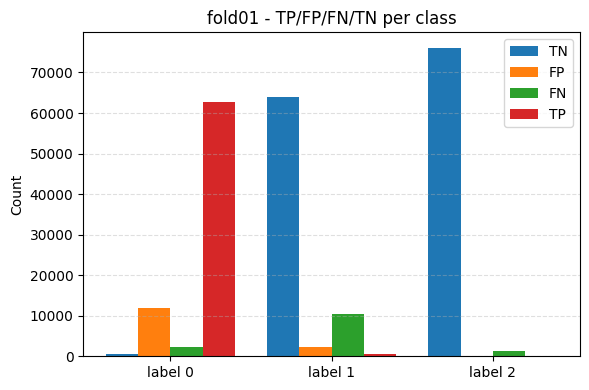

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


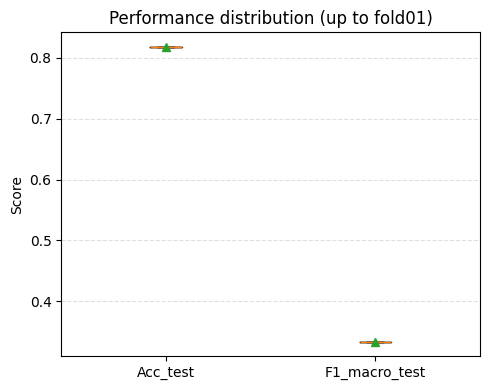


Training XGBoost for fold02
fold02 → Acc=0.8428, Macro-F1=0.3088


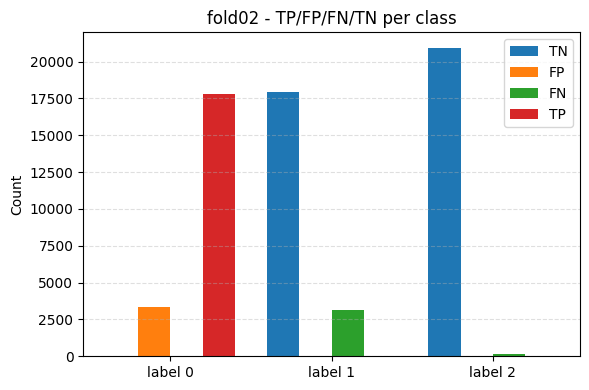

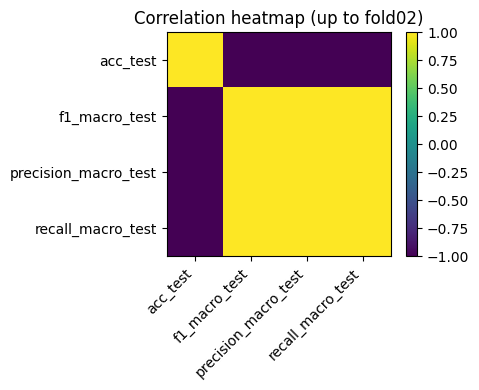

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


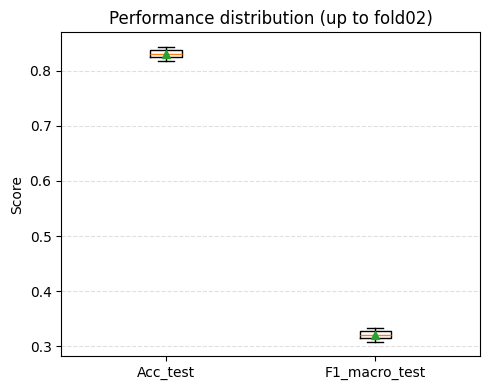


Training XGBoost for fold03
fold03 → Acc=0.8662, Macro-F1=0.3121


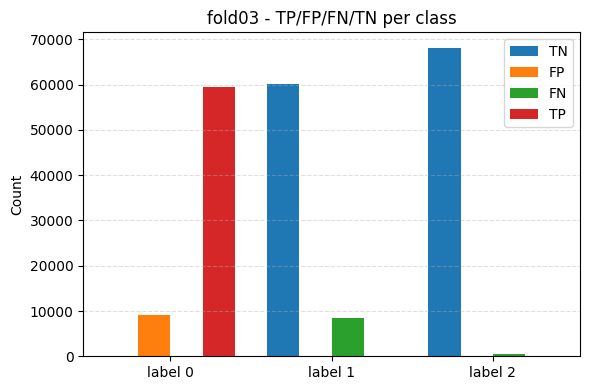

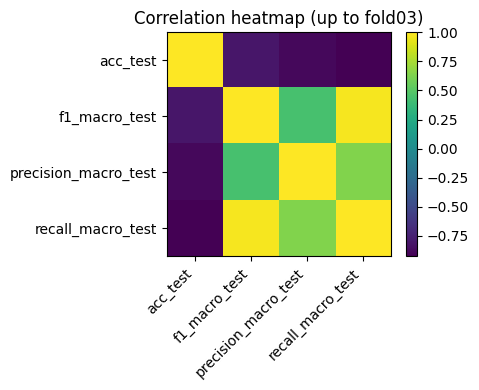

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


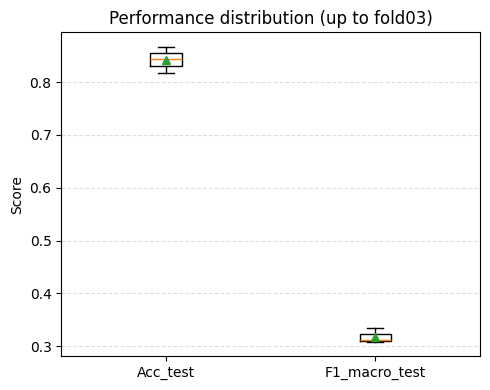


Training XGBoost for fold04
fold04 → Acc=0.8429, Macro-F1=0.4918


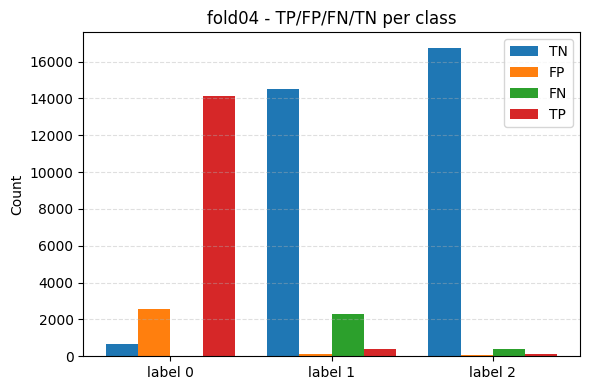

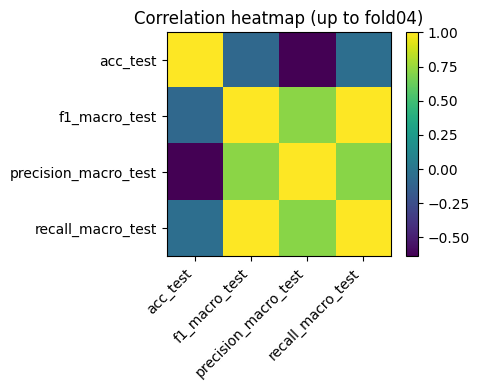

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


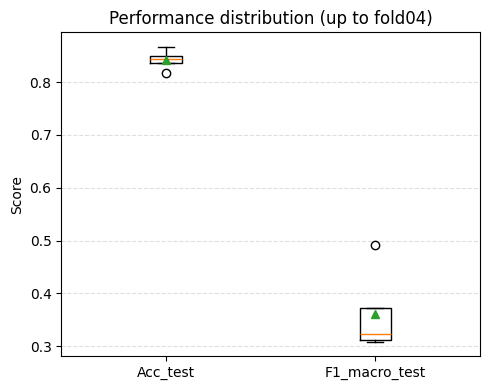


Training XGBoost for fold05
fold05 → Acc=0.8613, Macro-F1=0.4250


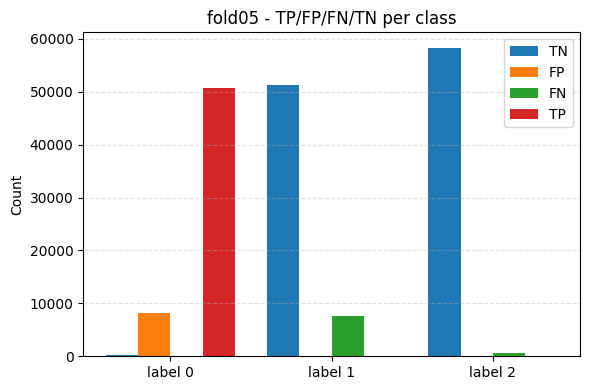

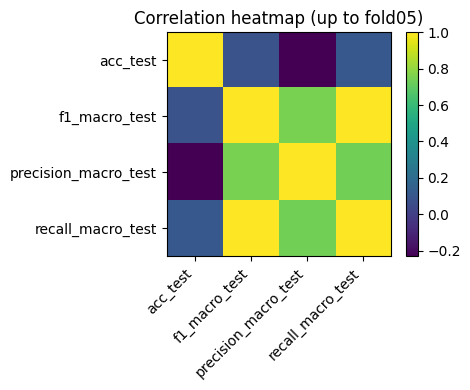

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


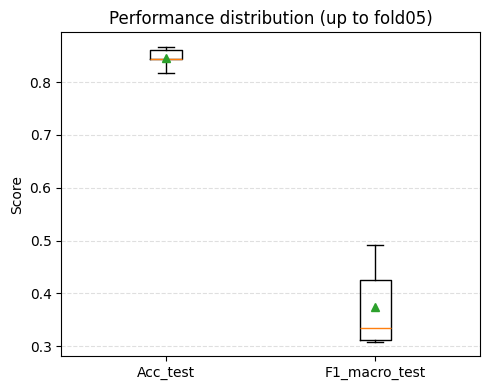


Training XGBoost for fold06
fold06 → Acc=0.8507, Macro-F1=0.3705


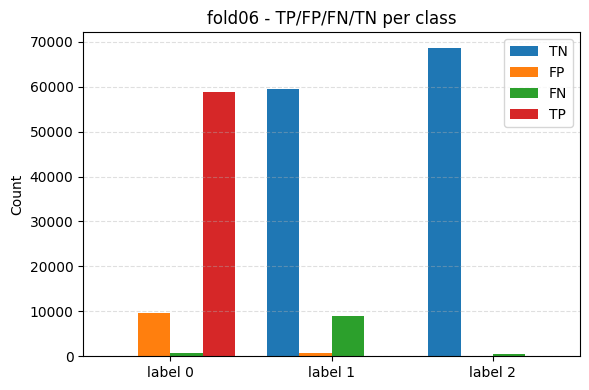

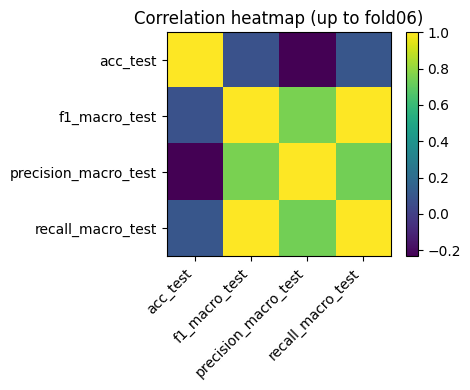

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


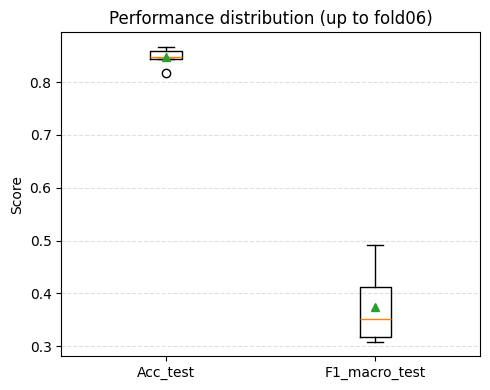


Training XGBoost for fold07
fold07 → Acc=0.7159, Macro-F1=0.3543


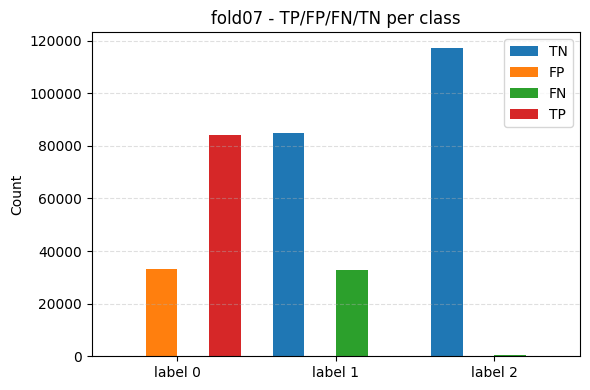

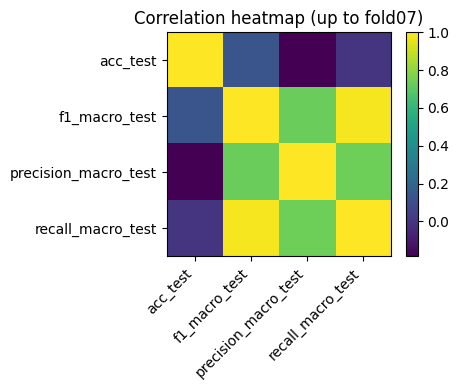

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


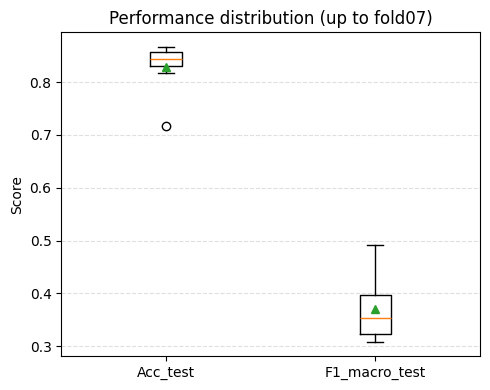


Training XGBoost for fold08
fold08 → Acc=0.7843, Macro-F1=0.3086


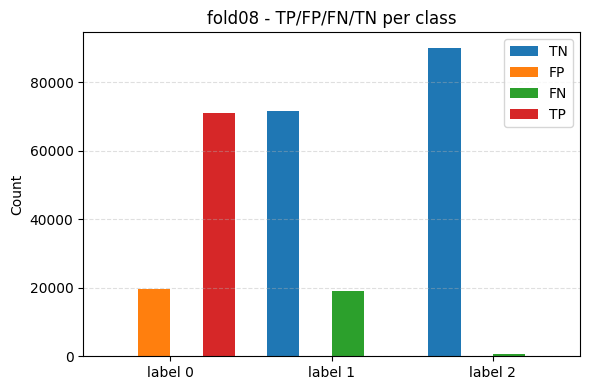

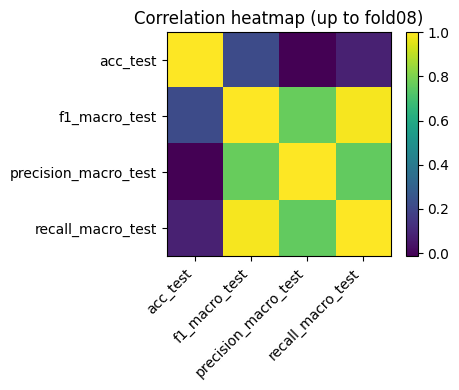

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


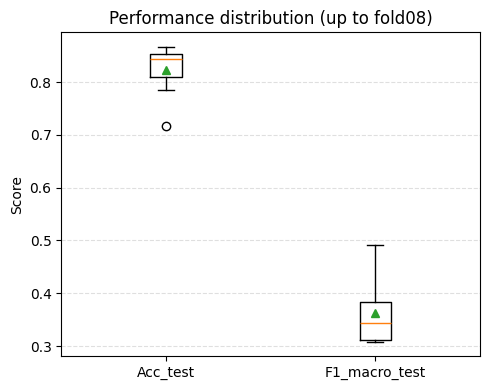


Training XGBoost for fold09
fold09 → Acc=0.8307, Macro-F1=0.4021


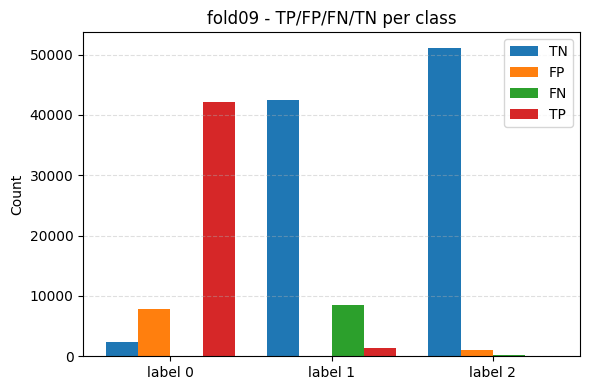

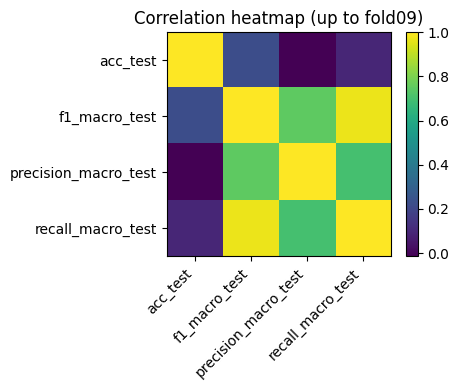

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


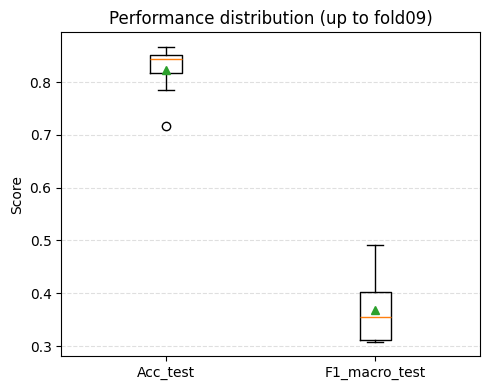


Training XGBoost for fold10
fold10 → Acc=0.8281, Macro-F1=0.3585


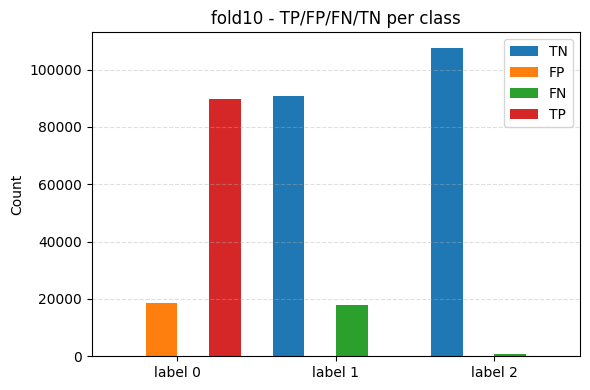

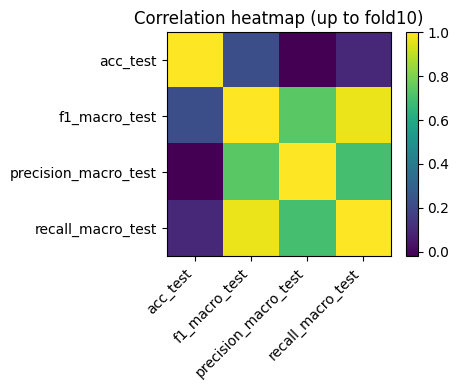

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


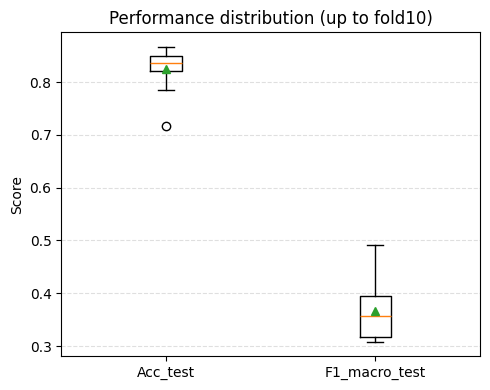


Training XGBoost for fold11
fold11 → Acc=0.8473, Macro-F1=0.3196


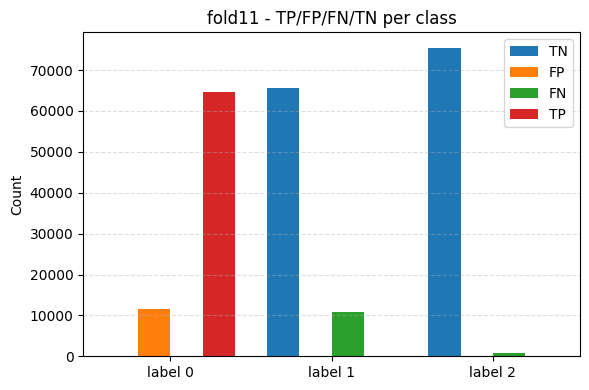

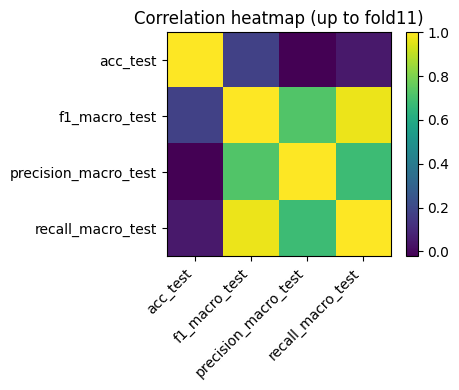

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


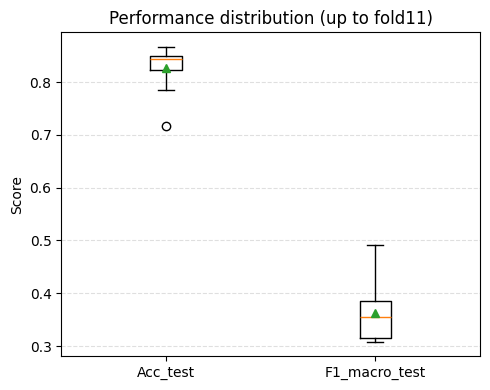


Training XGBoost for fold12
fold12 → Acc=0.8085, Macro-F1=0.3266


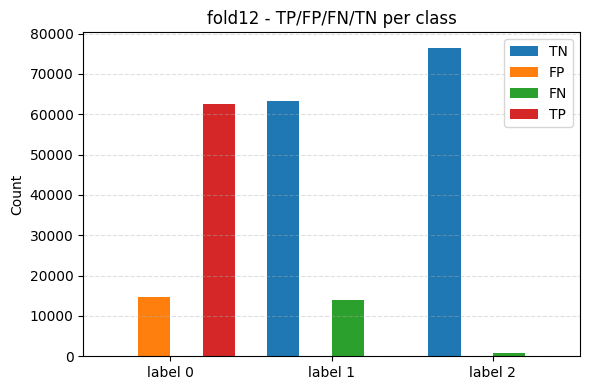

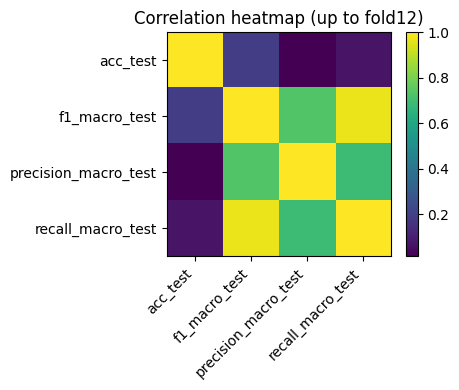

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


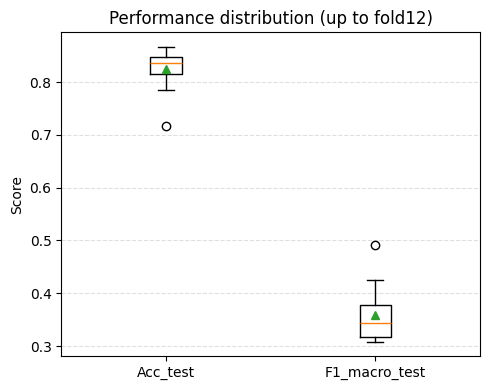


Training XGBoost for fold13
fold13 → Acc=0.8479, Macro-F1=0.4679


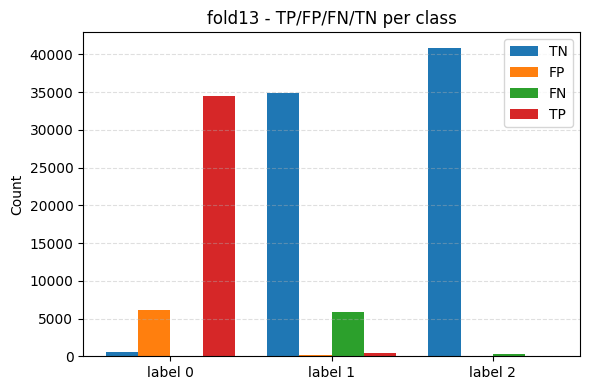

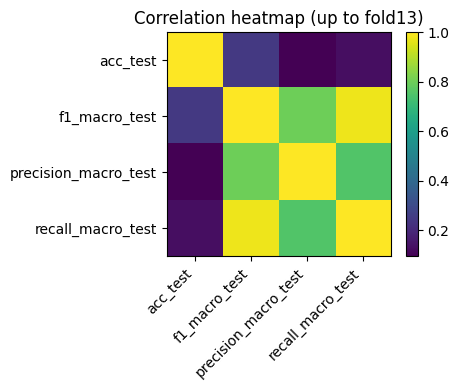

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


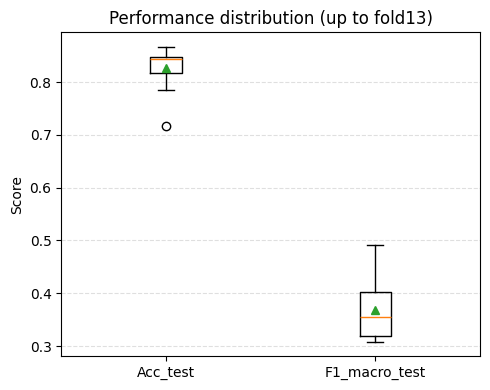


Training XGBoost for fold14
fold14 → Acc=0.8034, Macro-F1=0.3212


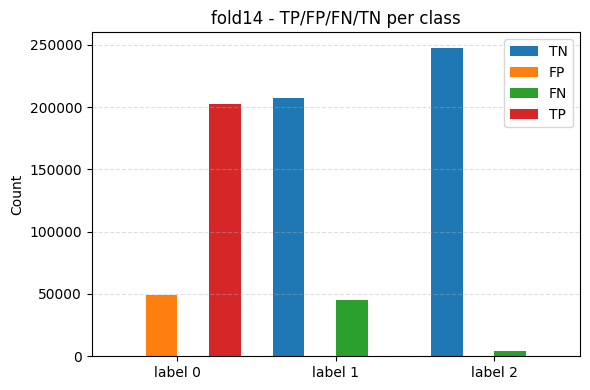

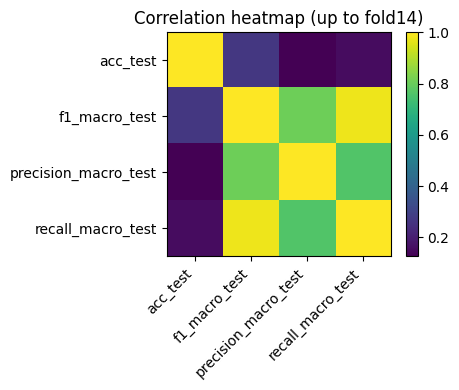

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


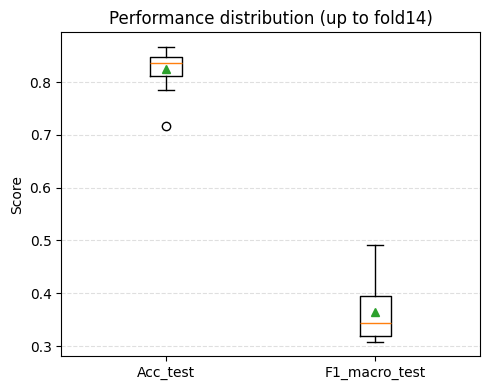


Training XGBoost for fold15
fold15 → Acc=0.8328, Macro-F1=0.3428


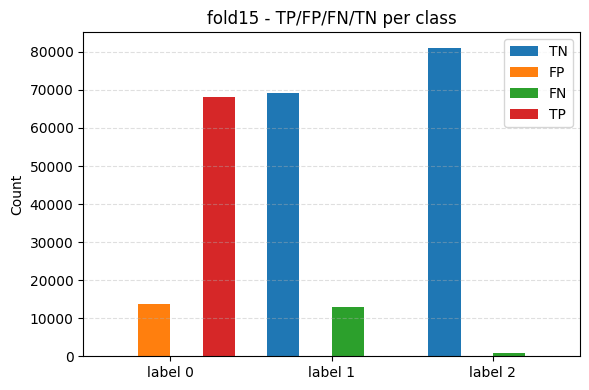

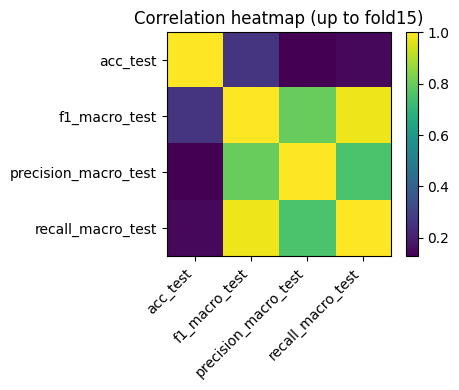

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


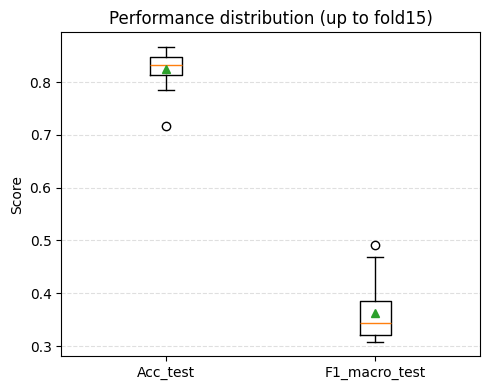


Training XGBoost for fold16
fold16 → Acc=0.7999, Macro-F1=0.3653


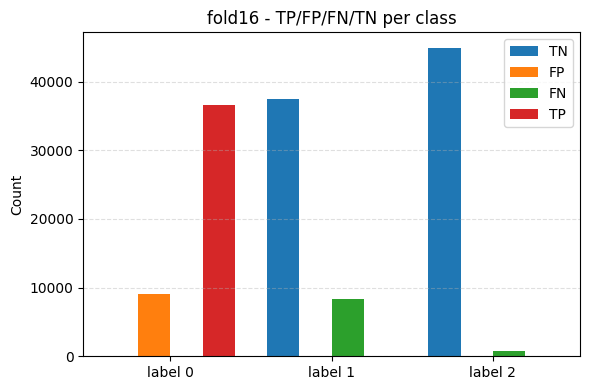

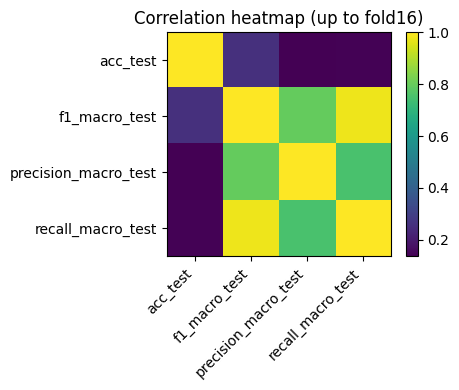

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


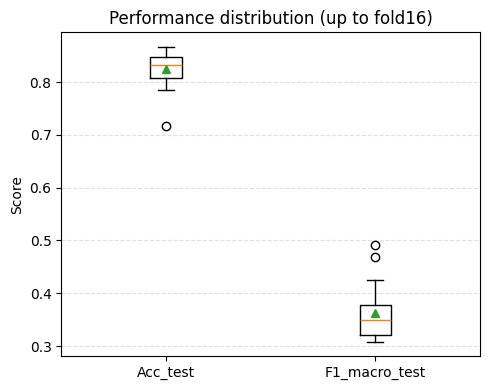


Training XGBoost for fold17
fold17 → Acc=0.6585, Macro-F1=0.2889


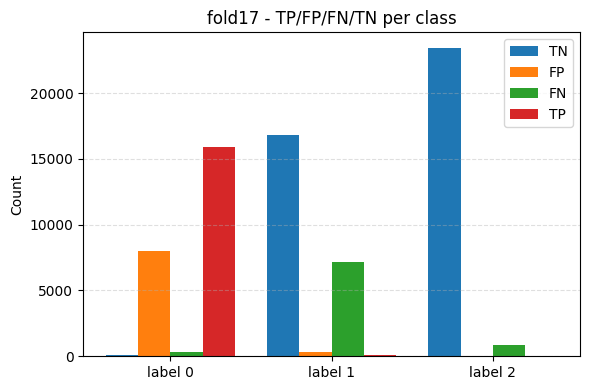

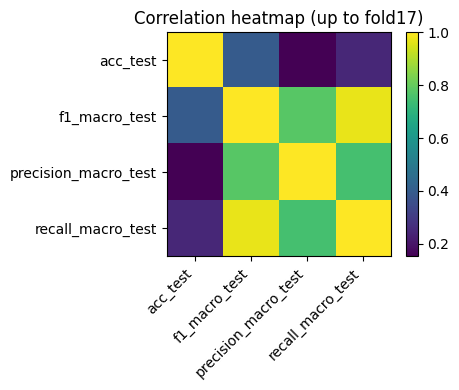

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


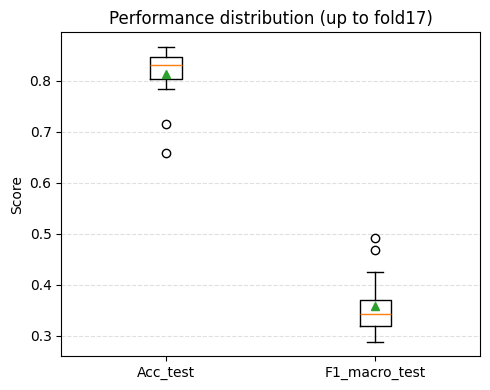


Training XGBoost for fold18
fold18 → Acc=0.7883, Macro-F1=0.3880


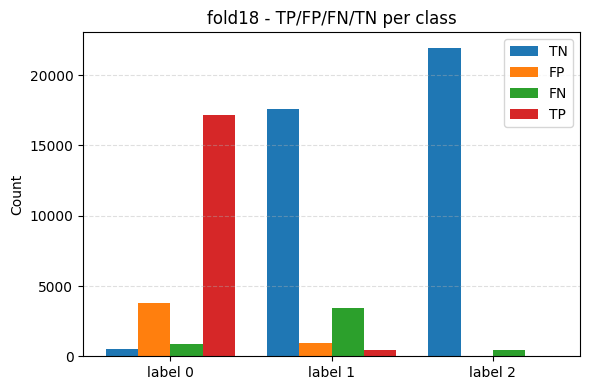

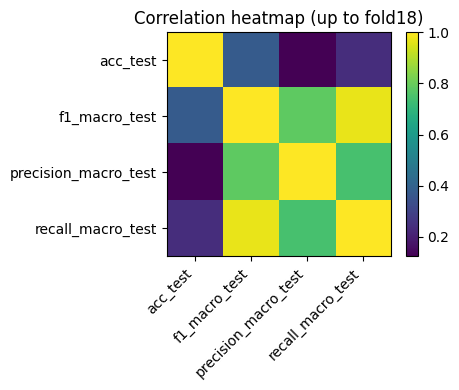

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


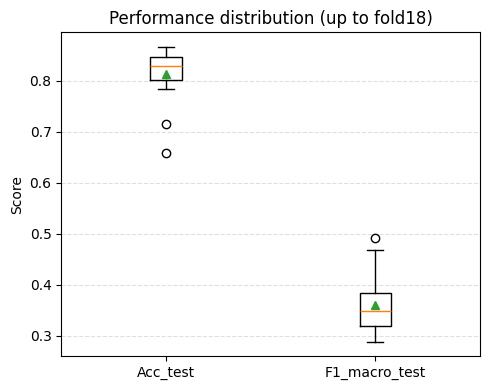


Training XGBoost for fold19
fold19 → Acc=0.8512, Macro-F1=0.3391


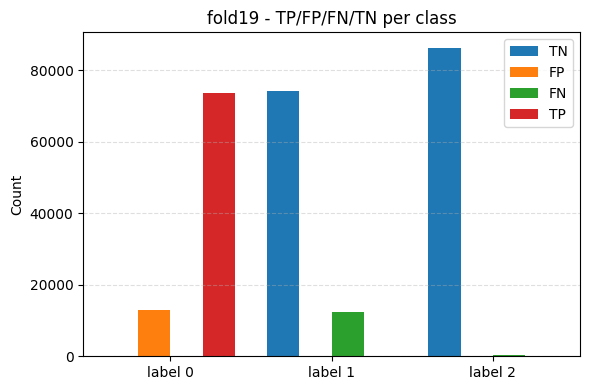

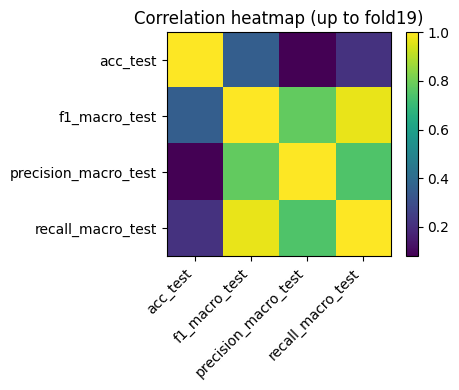

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


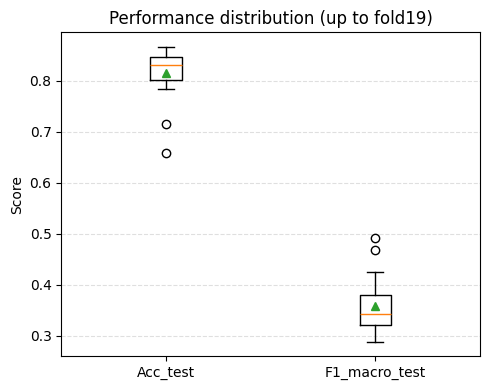


Training XGBoost for fold20
fold20 → Acc=0.7068, Macro-F1=0.3668


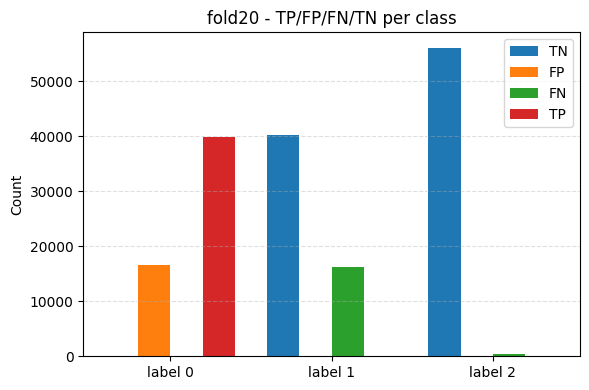

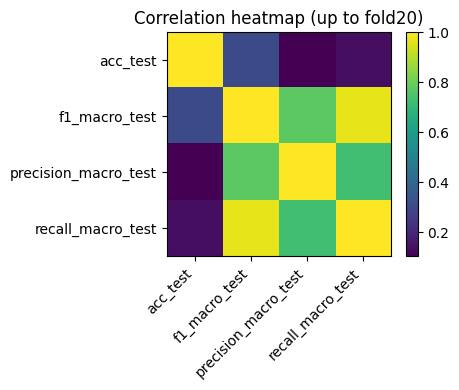

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


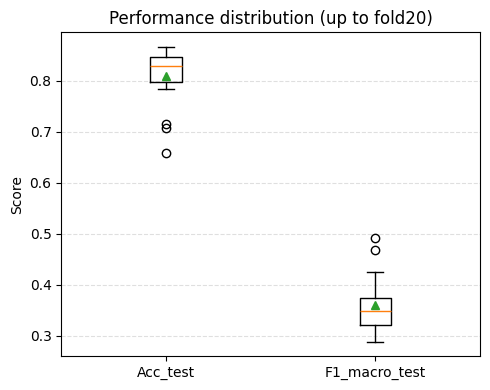


Training XGBoost for fold21
fold21 → Acc=0.8560, Macro-F1=0.4156


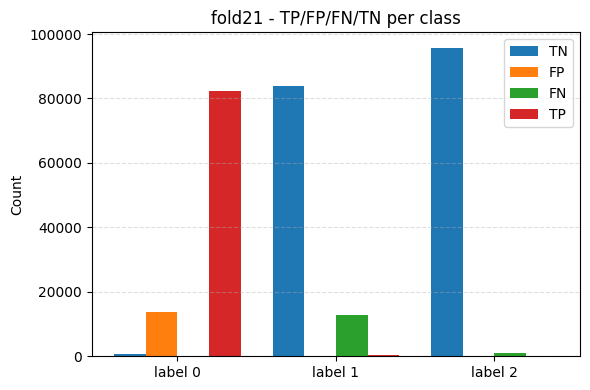

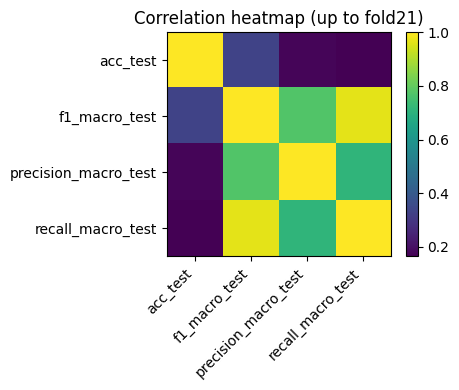

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


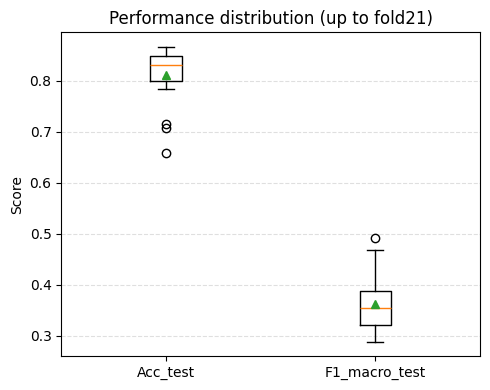


Training XGBoost for fold22
fold22 → Acc=0.7623, Macro-F1=0.3646


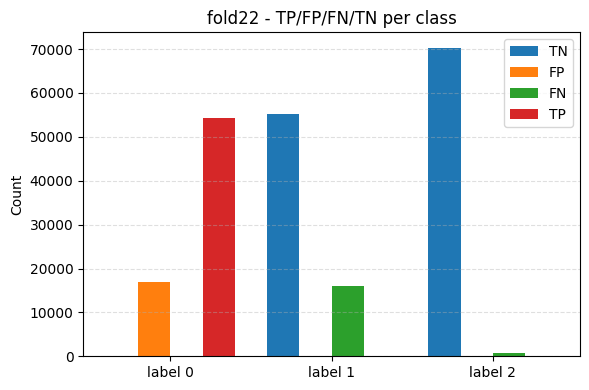

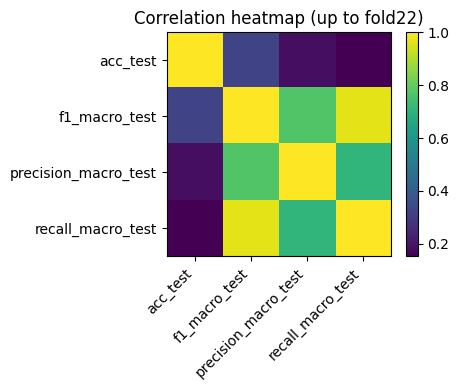

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


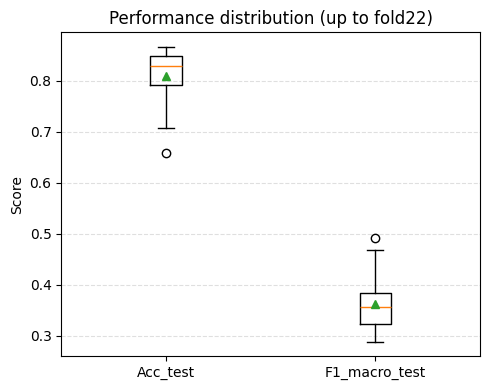


Training XGBoost for fold23
fold23 → Acc=0.6340, Macro-F1=0.3144


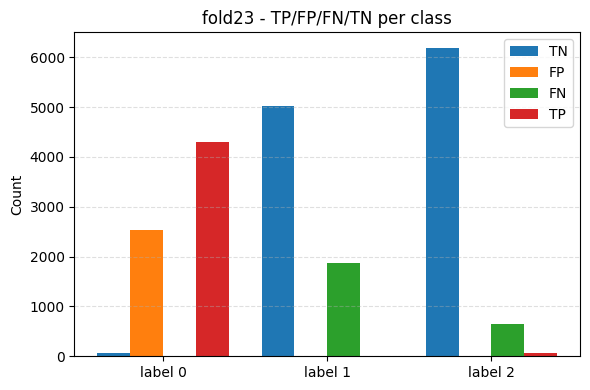

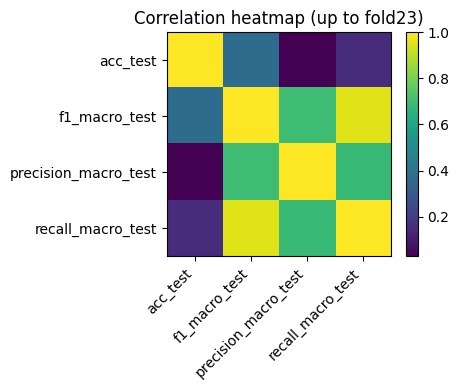

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\3348452392.py:222: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


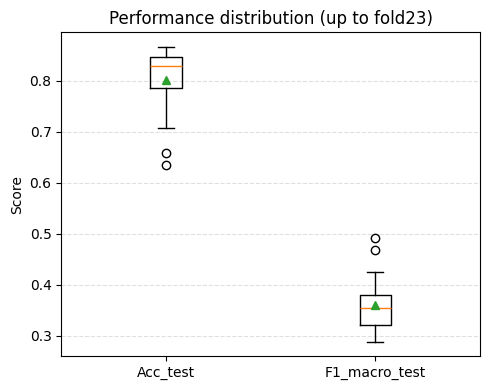


===== DONE: all folds trained & logged (multi-class) =====
Metrics file: C:\SeniorProject\Merged_Data\Split_Data_5fold_subjects\XGB_fold_metrics_multi.csv


In [ ]:
import os
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score,
    precision_score, recall_score,
    confusion_matrix
)

import matplotlib.pyplot as plt

# ============================================================
# 0) CONFIG
# ============================================================
SPLIT_DIR   = r"C:\SeniorProject\Merged_Data\Split_Data_5fold_subjects"
OUT_METRICS = os.path.join(SPLIT_DIR, "XGB_fold_metrics_multi.csv")  # Single metrics output file

meta_cols = ["subject", "run", "window_idx", "label"]

# If you want to restart from scratch, remove the previous metrics file
if os.path.exists(OUT_METRICS):
    os.remove(OUT_METRICS)
    print("Old metrics file removed:", OUT_METRICS)

# Detect available folds (fold01, fold02, ...)
all_files = [f for f in os.listdir(SPLIT_DIR) if f.endswith("_train.csv")]
folds = sorted({f.split("_")[0] for f in all_files})

print("Found folds:", folds)

# ============================================================
# 1) Use the first fold to infer number of classes and features
# ============================================================
if not folds:
    raise RuntimeError("❌ No folds found in the directory!")

sample_train = pd.read_csv(os.path.join(SPLIT_DIR, f"{folds[0]}_train.csv"))

# Sorted labels (e.g., array([0, 1, 2]))
labels_sorted = np.sort(sample_train["label"].unique())
num_classes = len(labels_sorted)

print("Labels found:", labels_sorted)
print("Num classes:", num_classes)

feat_cols = [c for c in sample_train.columns if c not in meta_cols]
print("Num features:", len(feat_cols))

# ============================================================
# 2) LOOP over all folds: train XGBoost + log one row of metrics + plots
# ============================================================
for fold in folds:
    print("\n======================================")
    print(f"Training XGBoost for {fold}")
    print("======================================")

    # -----------------------------
    # Load data for this fold
    # -----------------------------
    train_path = os.path.join(SPLIT_DIR, f"{fold}_train.csv")
    val_path   = os.path.join(SPLIT_DIR, f"{fold}_val.csv")
    test_path  = os.path.join(SPLIT_DIR, f"{fold}_test.csv")

    df_train = pd.read_csv(train_path)
    df_val   = pd.read_csv(val_path)
    df_test  = pd.read_csv(test_path)

    X_train = df_train[feat_cols].to_numpy(dtype=np.float32)
    y_train = df_train["label"].to_numpy(dtype=int)

    X_val   = df_val[feat_cols].to_numpy(dtype=np.float32)
    y_val   = df_val["label"].to_numpy(dtype=int)

    X_test  = df_test[feat_cols].to_numpy(dtype=np.float32)
    y_test  = df_test["label"].to_numpy(dtype=int)

    # -----------------------------
    # Define XGBoost model for multi-class (3 labels)
    # -----------------------------
    model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        random_state=42,
        n_jobs=-1,
        # multi-class
        objective="multi:softprob",
        num_class=num_classes,
        eval_metric="mlogloss",
    )

    # -----------------------------
    # Train the model
    # -----------------------------
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # -----------------------------
    # Predict on the test set
    # -----------------------------
    y_pred = model.predict(X_test)

    # Global metrics (multi-class compatible)
    acc_test   = accuracy_score(y_test, y_pred)
    f1_macro   = f1_score(y_test, y_pred, average="macro")
    prec_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec_macro  = recall_score(y_test, y_pred, average="macro", zero_division=0)

    print(f"{fold} → Acc={acc_test:.4f}, Macro-F1={f1_macro:.4f}")

    # -----------------------------
    # Confusion Matrix (3x3)
    # -----------------------------
    cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)

    # -----------------------------
    # Compute TP / FP / FN / TN for each class
    # -----------------------------
    metrics_row = {
        "fold": fold,
        "num_test_samples": len(y_test),
        "acc_test": acc_test,
        "f1_macro_test": f1_macro,
        "precision_macro_test": prec_macro,
        "recall_macro_test": rec_macro,
    }

    tp_list = []
    fp_list = []
    fn_list = []
    tn_list = []

    total = cm.sum()

    for i, lab in enumerate(labels_sorted):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = total - (tp + fp + fn)

        tp_list.append(tp)
        fp_list.append(fp)
        fn_list.append(fn)
        tn_list.append(tn)

        metrics_row[f"tp_label{lab}"] = tp
        metrics_row[f"fp_label{lab}"] = fp
        metrics_row[f"fn_label{lab}"] = fn
        metrics_row[f"tn_label{lab}"] = tn

    # -----------------------------
    # 🔹 Bar plot of TP / FP / FN / TN per class
    # -----------------------------
    plt.figure(figsize=(6, 4))

    x = np.arange(len(labels_sorted))  # positions: 0, 1, 2, ...
    width = 0.2

    plt.bar(x - 1.5 * width, tn_list, width, label="TN")
    plt.bar(x - 0.5 * width, fp_list, width, label="FP")
    plt.bar(x + 0.5 * width, fn_list, width, label="FN")
    plt.bar(x + 1.5 * width, tp_list, width, label="TP")

    plt.xticks(x, [f"label {lab}" for lab in labels_sorted])
    plt.ylabel("Count")
    plt.title(f"{fold} - TP/FP/FN/TN per class")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Append this fold's metrics row into the metrics file
    # -----------------------------
    row_df = pd.DataFrame([metrics_row])
    header_needed = not os.path.exists(OUT_METRICS)
    row_df.to_csv(OUT_METRICS, mode="a", header=header_needed, index=False)

    # =======================================================
    # Extra plots after each model:
    #   - Correlation heatmap for main metrics
    #   - Boxplot for Acc / Macro-F1 distribution across folds so far
    # =======================================================
    metrics_so_far = pd.read_csv(OUT_METRICS)

    # ---- Correlation heatmap ----
    corr_cols = [
        "acc_test",
        "f1_macro_test",
        "precision_macro_test",
        "recall_macro_test",
    ]

    # Ensure columns exist and remove NaNs
    corr_data = metrics_so_far[corr_cols].dropna()

    # At least 2 folds are needed for a meaningful correlation
    if len(corr_data) >= 2:
        corr = corr_data.corr()

        plt.figure(figsize=(5, 4))
        plt.imshow(corr, interpolation="nearest")
        plt.title(f"Correlation heatmap (up to {fold})")
        plt.colorbar()
        plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha="right")
        plt.yticks(range(len(corr_cols)), corr_cols)
        plt.tight_layout()
        plt.show()

    # ---- Boxplot for performance across folds (Acc & F1) ----
    plt.figure(figsize=(5, 4))
    acc_values = metrics_so_far["acc_test"].values
    f1_values  = metrics_so_far["f1_macro_test"].values

    plt.boxplot(
        [acc_values, f1_values],
        labels=["Acc_test", "F1_macro_test"],
        showmeans=True
    )
    plt.title(f"Performance distribution (up to {fold})")
    plt.ylabel("Score")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

print("\n===== DONE: all folds trained & logged (multi-class) =====")
print("Metrics file:", OUT_METRICS)


#### 2 | EEG

Found folds: ['fold01', 'fold02', 'fold03', 'fold04', 'fold05', 'fold06', 'fold07', 'fold08', 'fold09', 'fold10', 'fold11', 'fold12', 'fold13', 'fold14', 'fold15', 'fold16', 'fold17', 'fold18', 'fold19', 'fold20', 'fold21', 'fold22', 'fold23']
Labels found: [0 1 2]
Num classes: 3
Num features: 44

Training XGBoost for fold01
fold01 → Acc=0.8383, Macro-F1=0.3040


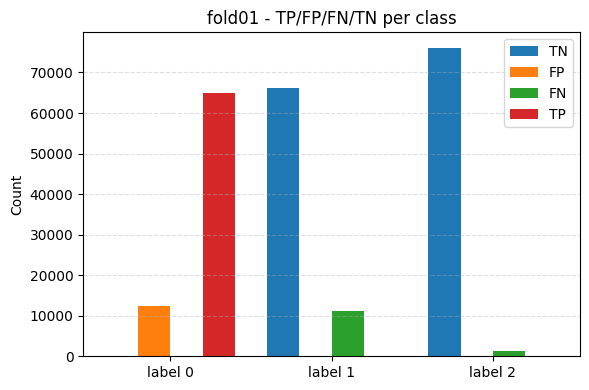

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


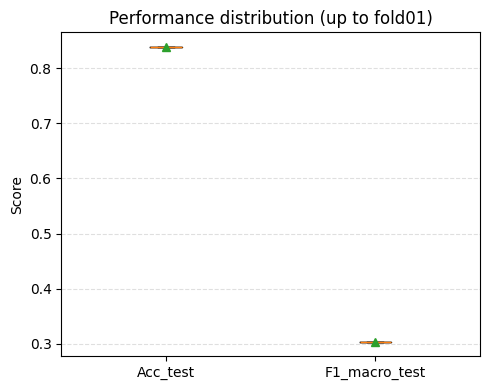


Training XGBoost for fold02
fold02 → Acc=0.8428, Macro-F1=0.3049


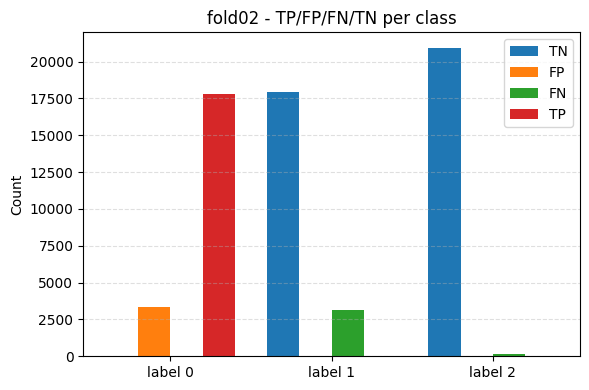

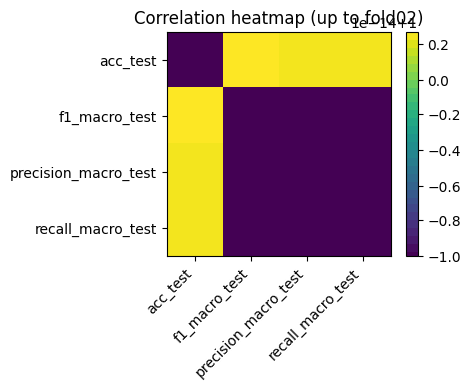

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


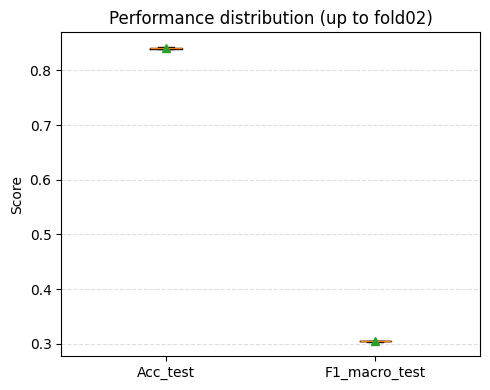


Training XGBoost for fold03
fold03 → Acc=0.8672, Macro-F1=0.3123


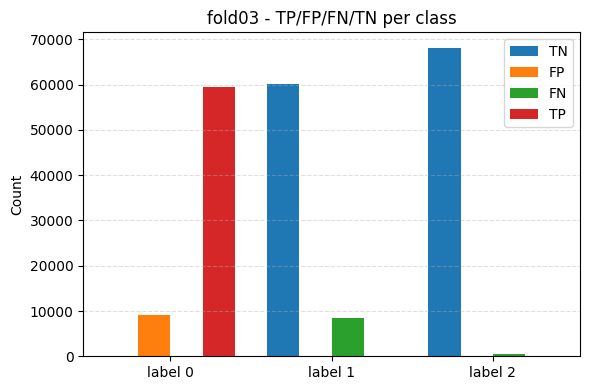

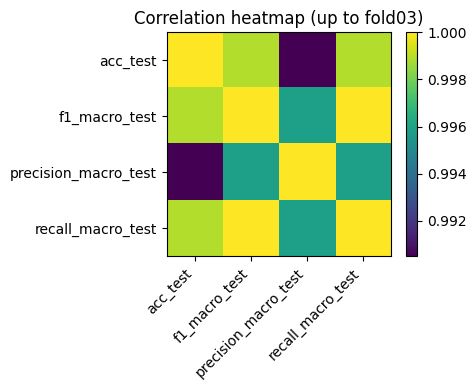

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


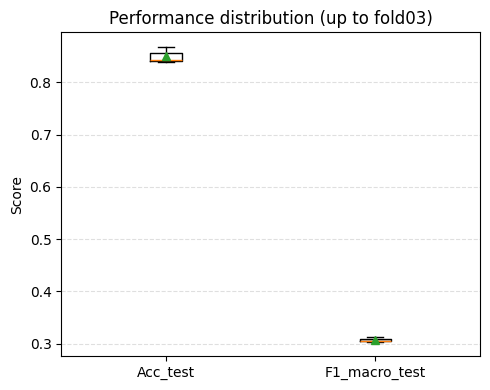


Training XGBoost for fold04
fold04 → Acc=0.8162, Macro-F1=0.3704


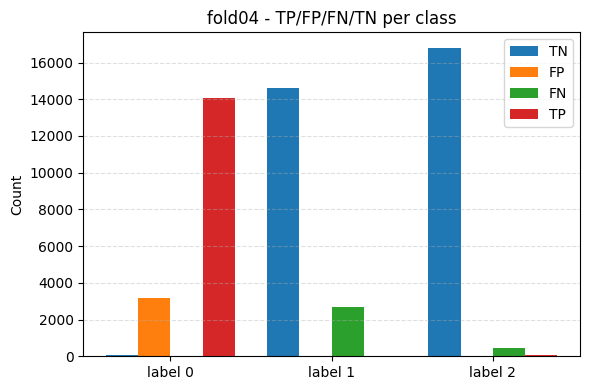

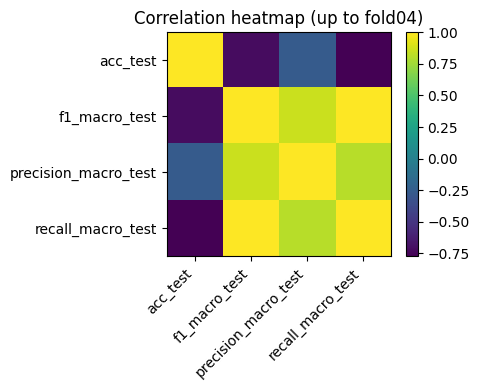

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


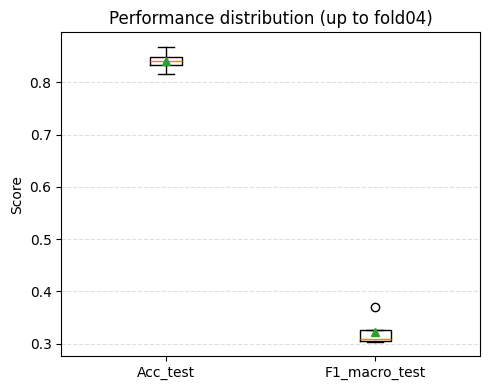


Training XGBoost for fold05
fold05 → Acc=0.8592, Macro-F1=0.3975


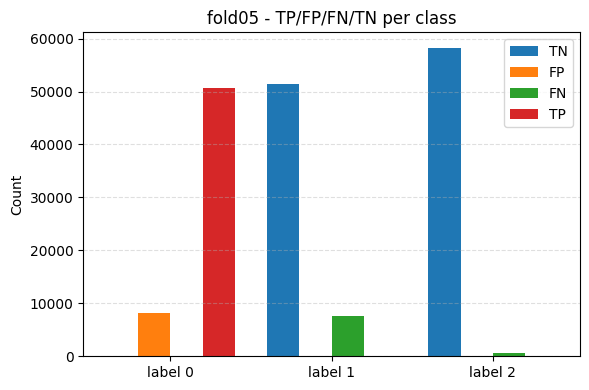

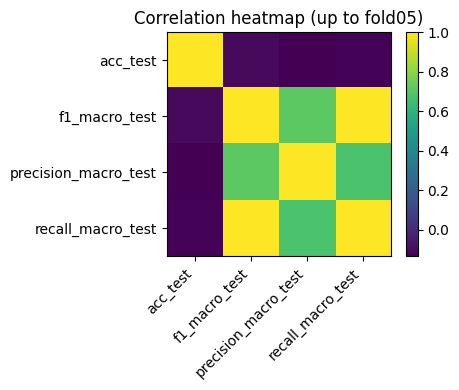

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


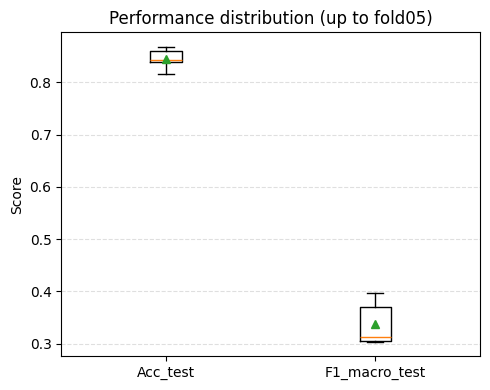


Training XGBoost for fold06
fold06 → Acc=0.8510, Macro-F1=0.3425


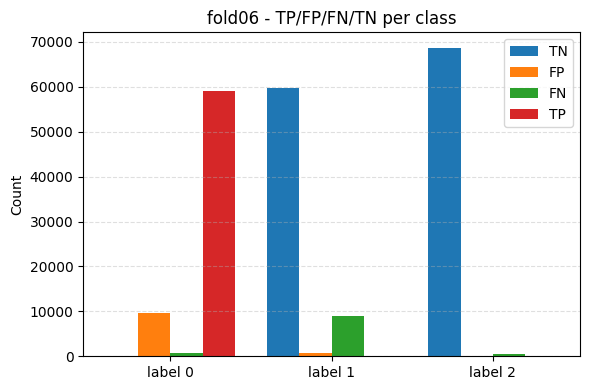

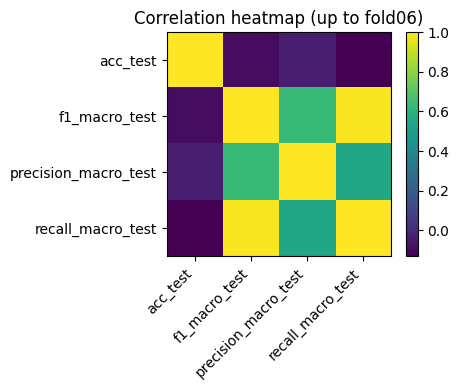

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


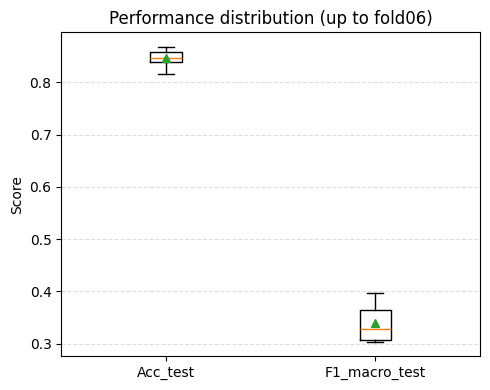


Training XGBoost for fold07
fold07 → Acc=0.7113, Macro-F1=0.3259


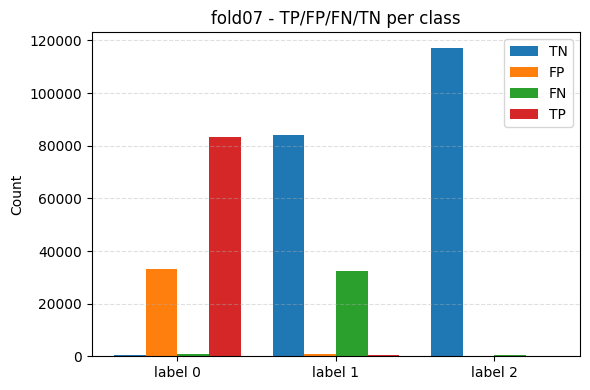

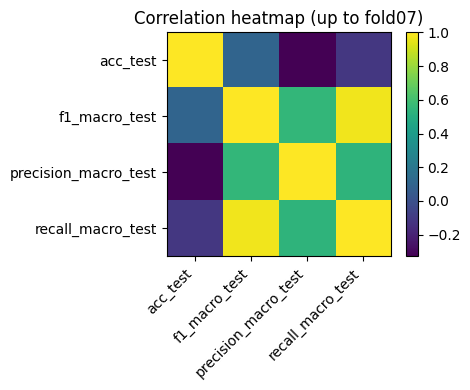

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


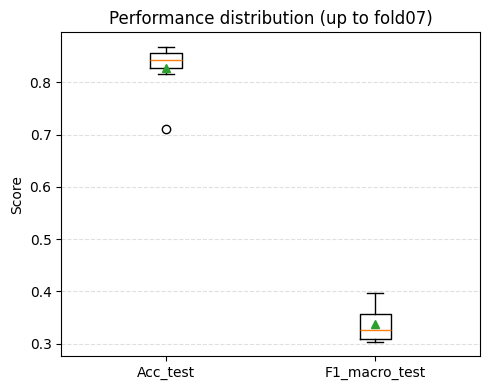


Training XGBoost for fold08
fold08 → Acc=0.7842, Macro-F1=0.2942


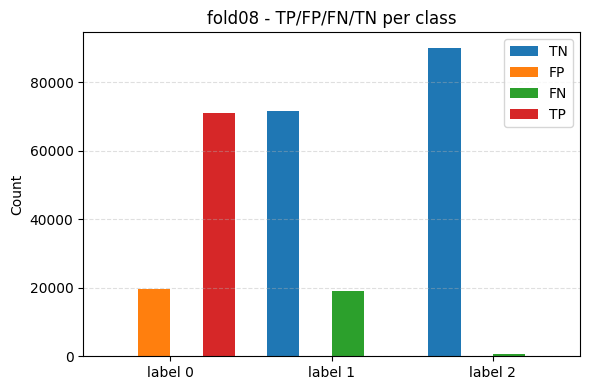

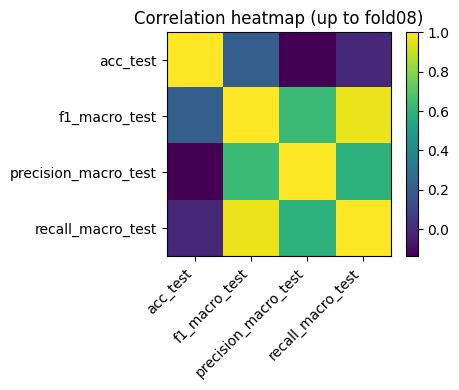

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


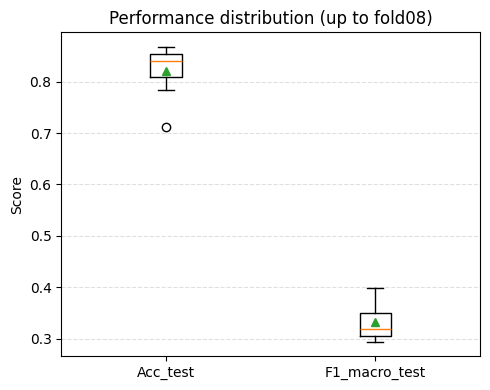


Training XGBoost for fold09
fold09 → Acc=0.8028, Macro-F1=0.3012


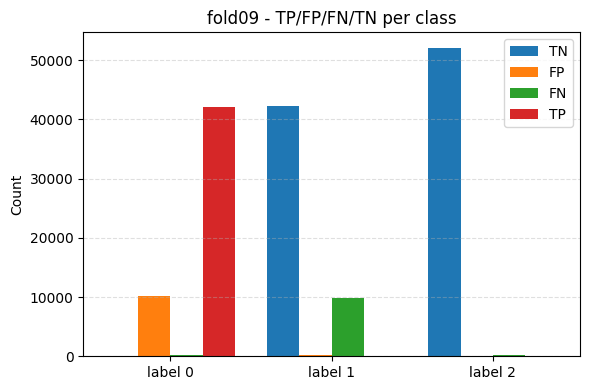

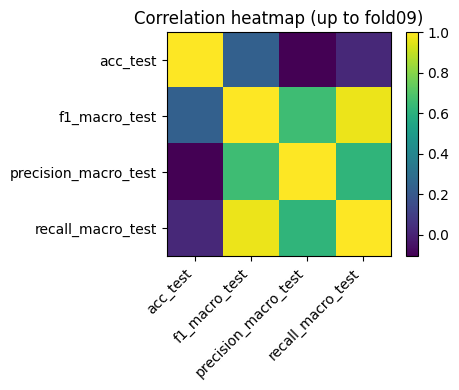

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


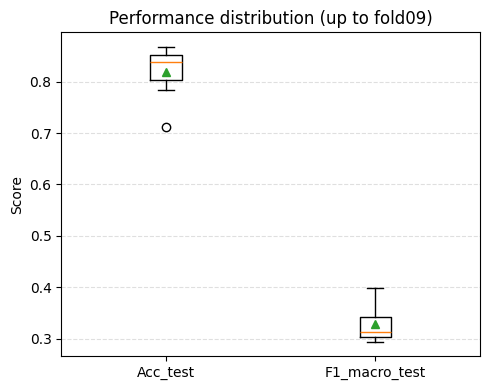


Training XGBoost for fold10
fold10 → Acc=0.8273, Macro-F1=0.3490


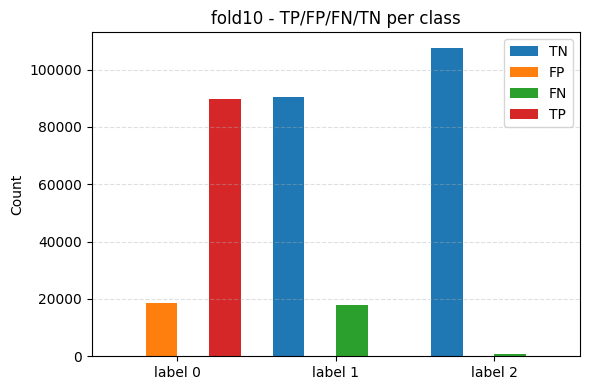

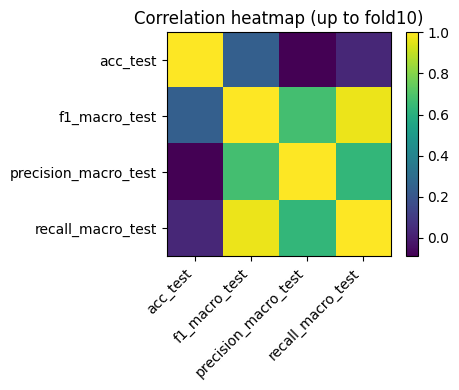

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


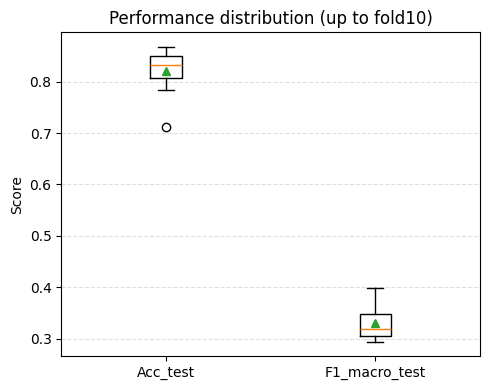


Training XGBoost for fold11
fold11 → Acc=0.8474, Macro-F1=0.3217


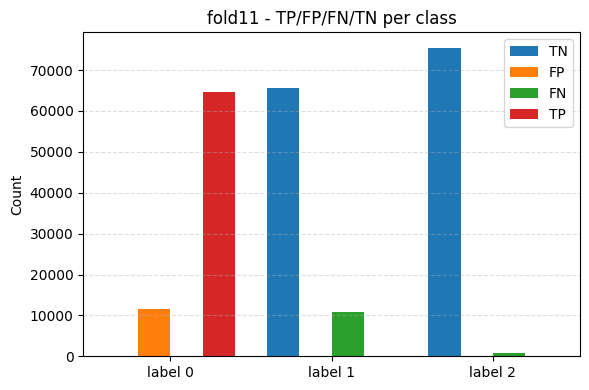

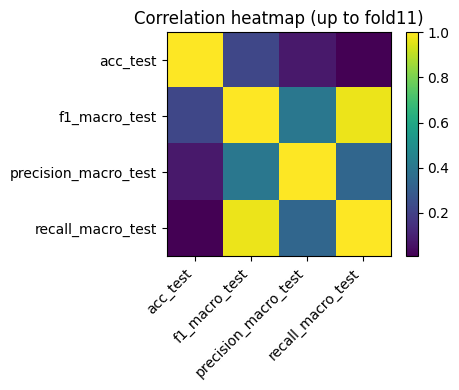

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


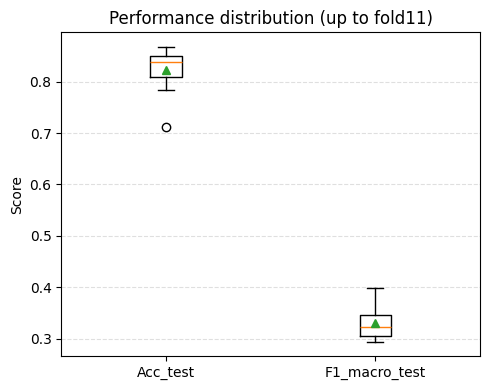


Training XGBoost for fold12
fold12 → Acc=0.8086, Macro-F1=0.3225


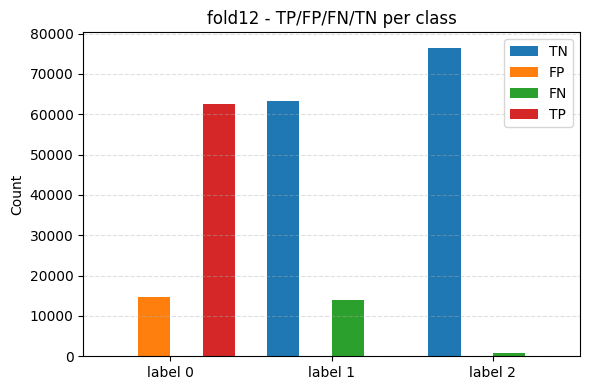

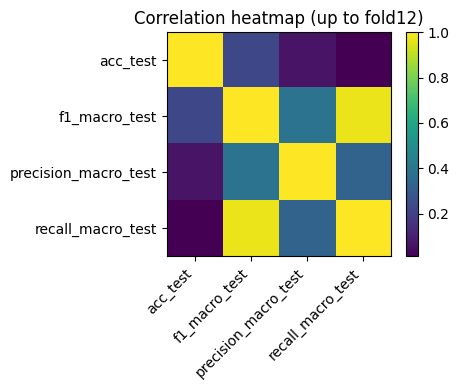

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


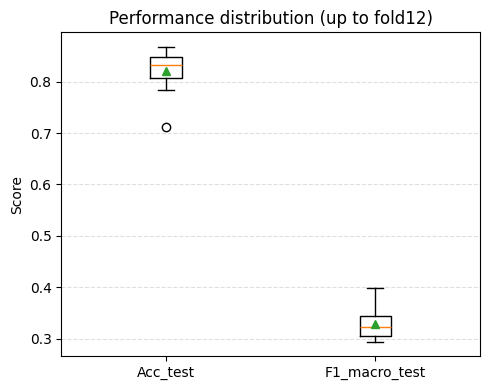


Training XGBoost for fold13
fold13 → Acc=0.8373, Macro-F1=0.3883


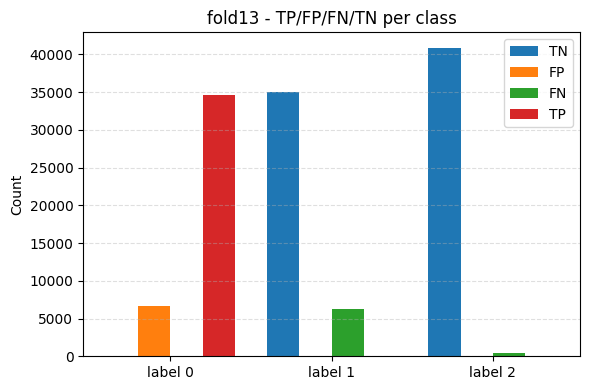

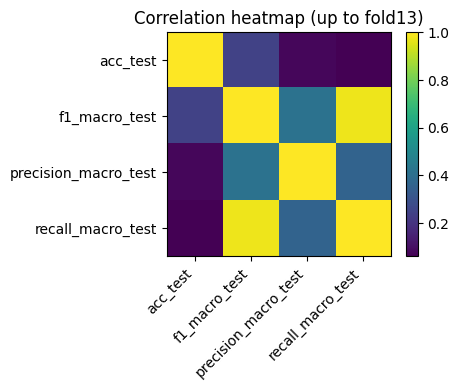

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


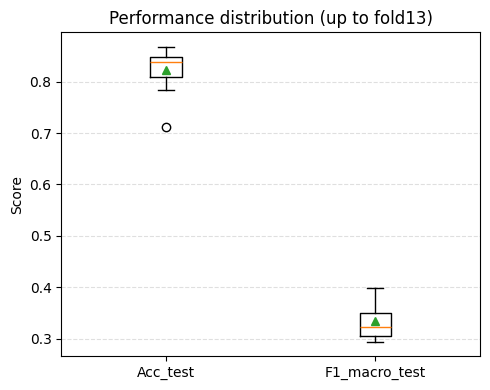


Training XGBoost for fold14
fold14 → Acc=0.8039, Macro-F1=0.3179


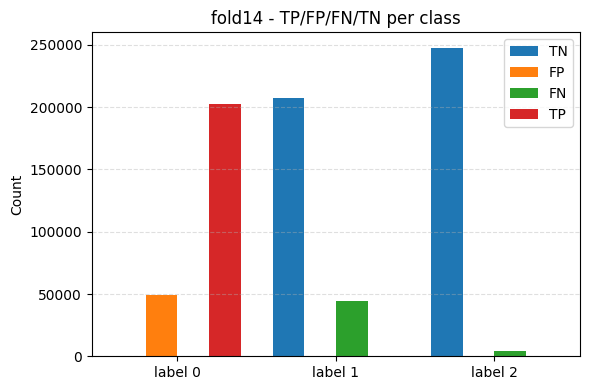

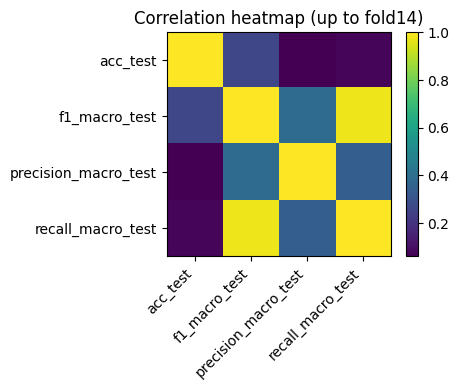

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


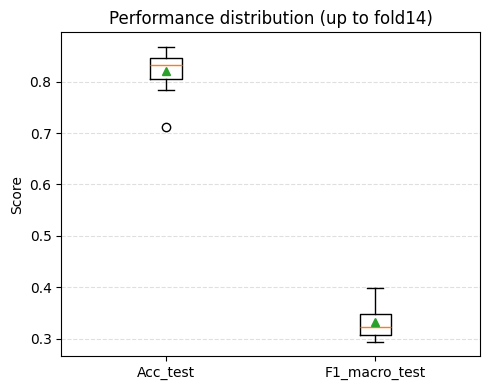


Training XGBoost for fold15
fold15 → Acc=0.8326, Macro-F1=0.3209


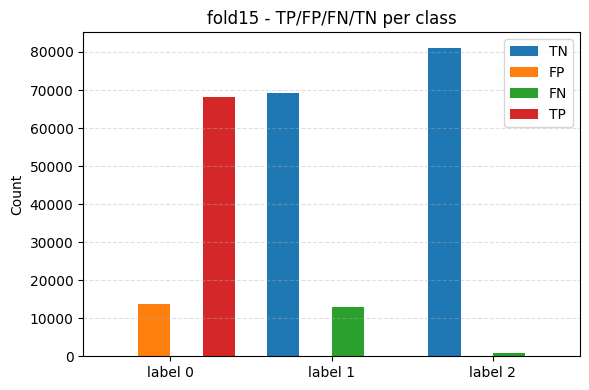

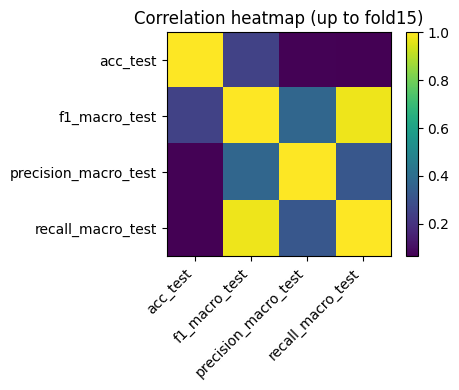

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


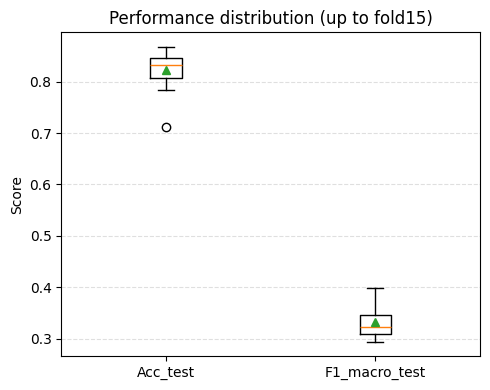


Training XGBoost for fold16
fold16 → Acc=0.7976, Macro-F1=0.3113


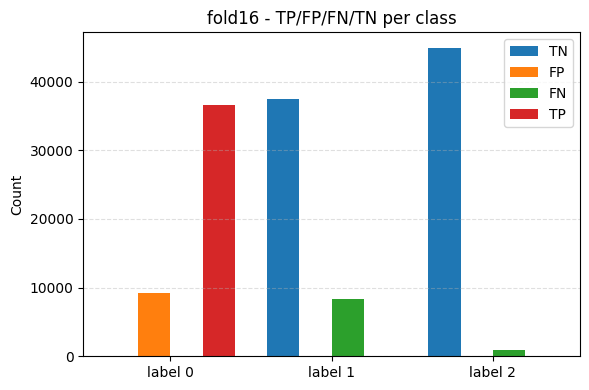

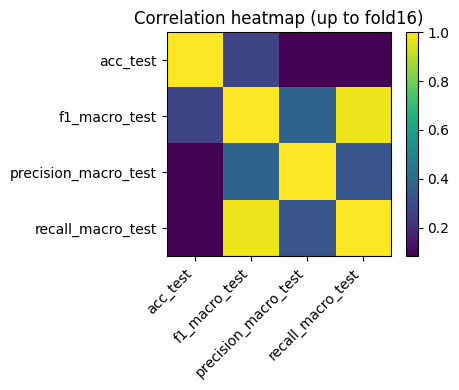

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


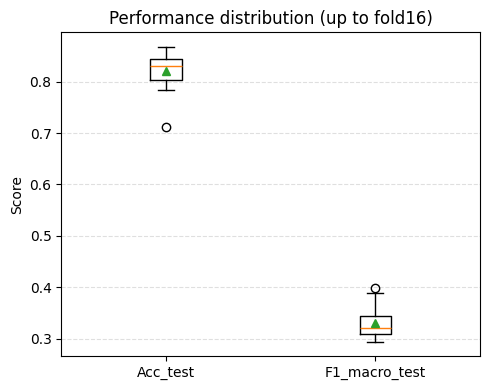


Training XGBoost for fold17
fold17 → Acc=0.6686, Macro-F1=0.2846


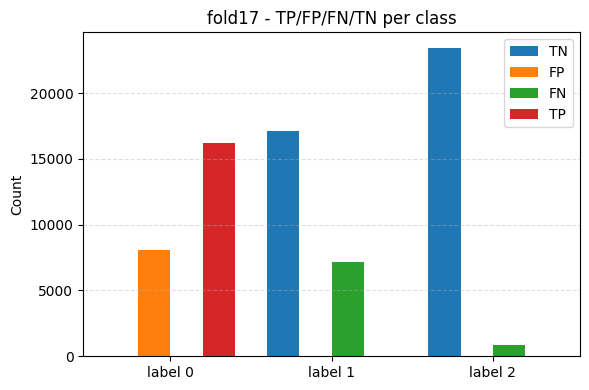

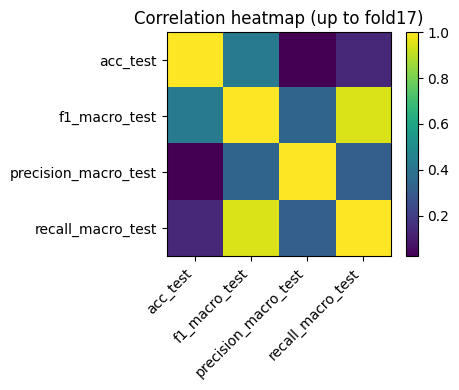

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


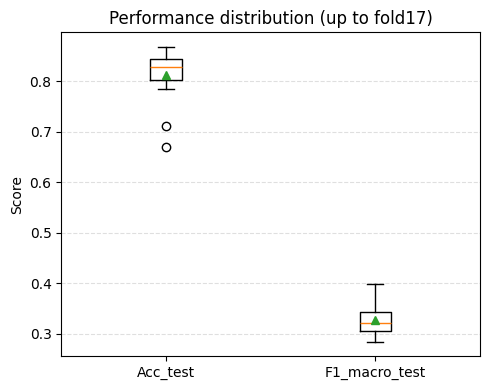


Training XGBoost for fold18
fold18 → Acc=0.8067, Macro-F1=0.3278


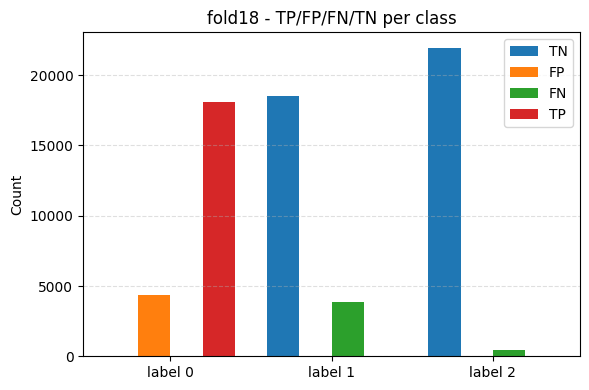

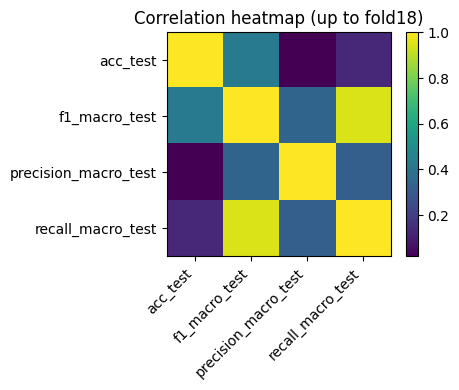

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


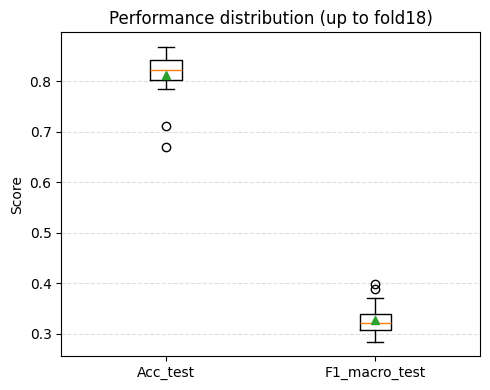


Training XGBoost for fold19
fold19 → Acc=0.8474, Macro-F1=0.3379


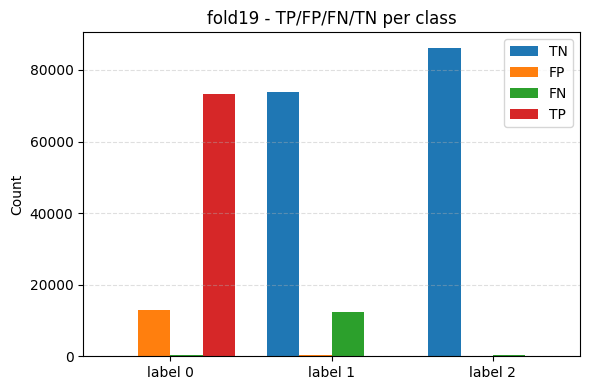

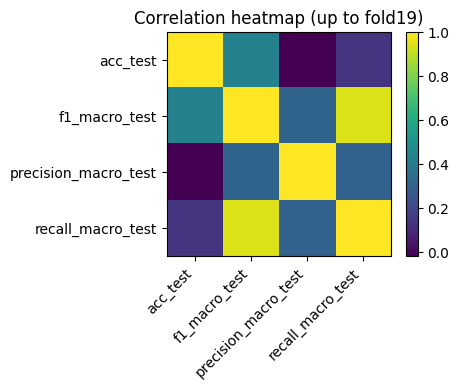

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


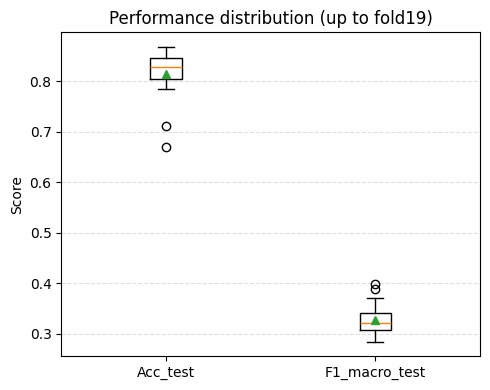


Training XGBoost for fold20
fold20 → Acc=0.7063, Macro-F1=0.3379


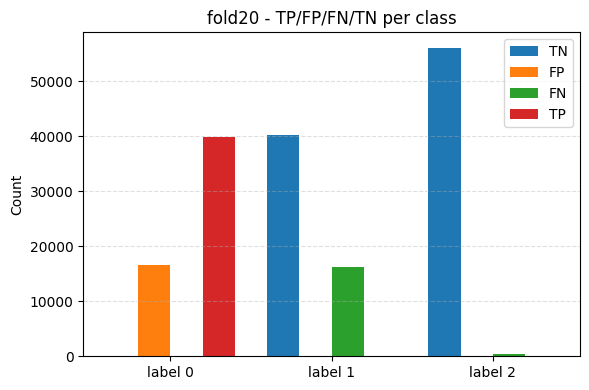

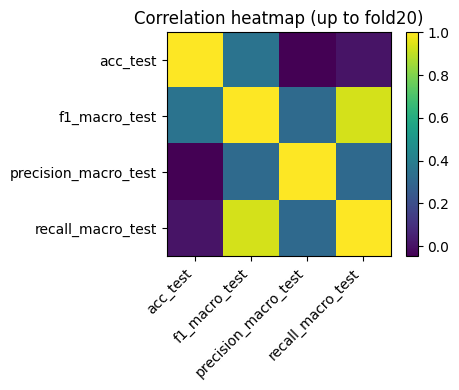

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


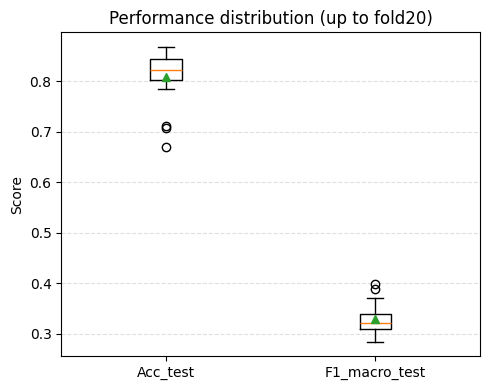


Training XGBoost for fold21
fold21 → Acc=0.8512, Macro-F1=0.3783


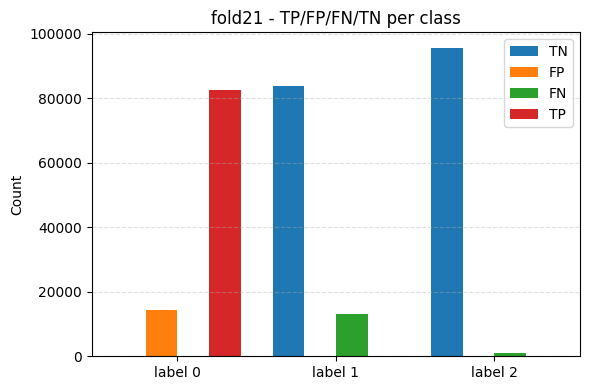

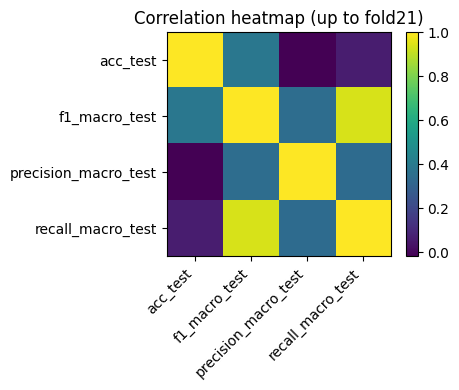

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


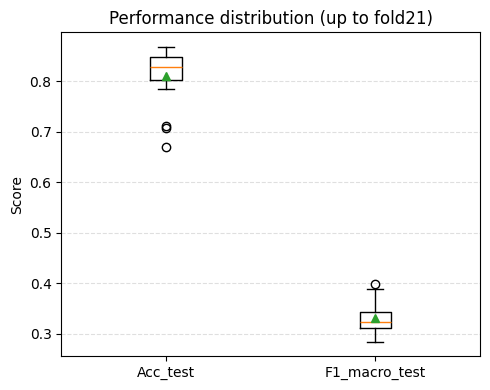


Training XGBoost for fold22
fold22 → Acc=0.7620, Macro-F1=0.3469


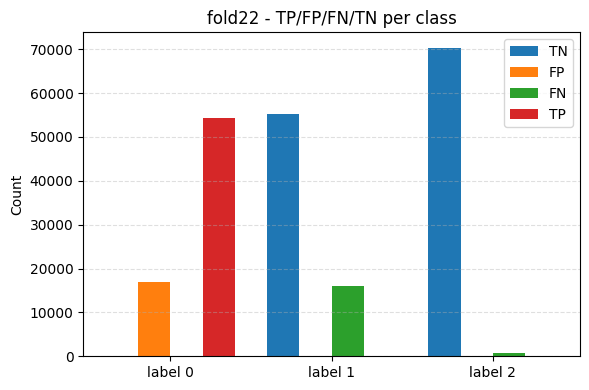

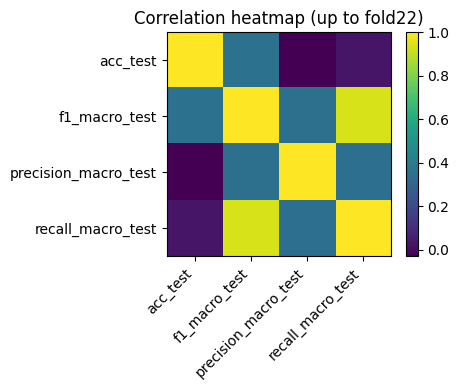

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


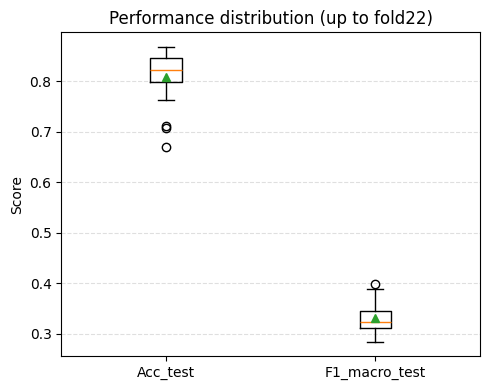


Training XGBoost for fold23
fold23 → Acc=0.6307, Macro-F1=0.2951


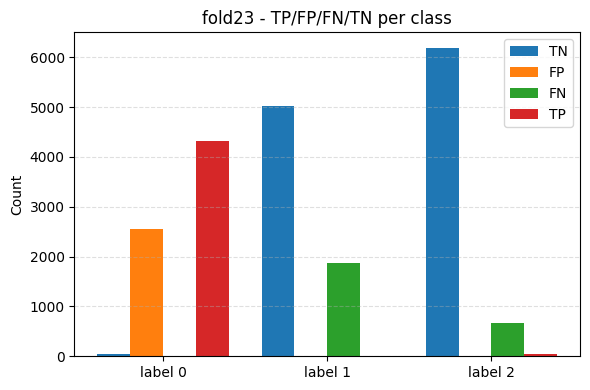

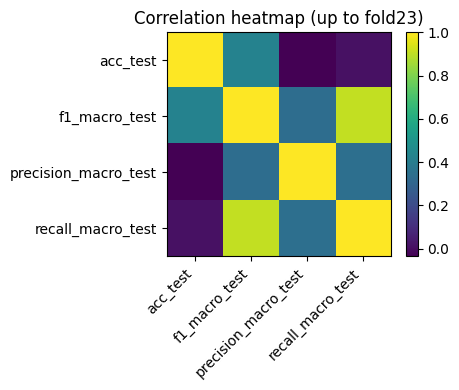

C:\Users\Shouq\AppData\Local\Temp\ipykernel_21560\2314378889.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


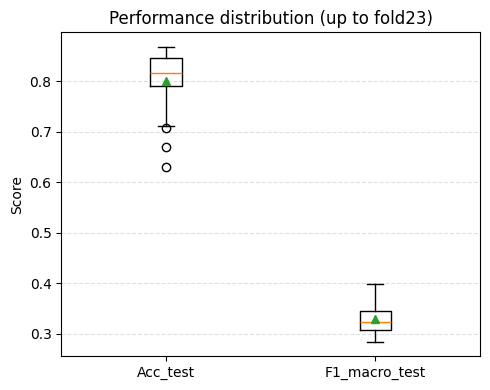


===== DONE: all folds trained & logged (multi-class) =====
Metrics file: C:\SeniorProject\Merged_Data\Split_Data_5fold_subjects\XGB_fold_metrics_multi_EEG.csv


In [40]:
import os
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score,
    precision_score, recall_score,
    confusion_matrix
)

import matplotlib.pyplot as plt

# ============================================================
# 0) CONFIG
# ============================================================
SPLIT_DIR   = r"C:\SeniorProject\Merged_Data\Split_Data_5fold_subjects"
OUT_METRICS = os.path.join(SPLIT_DIR, "XGB_fold_metrics_multi_EEG.csv")  # ملف النتائج الوحيد

meta_cols = ["subject", "run", "window_idx", "label"]

# لو تبغي تعيدين من الصفر يمسح الملف القديم
if os.path.exists(OUT_METRICS):
    os.remove(OUT_METRICS)
    print("Old metrics file removed:", OUT_METRICS)

# نكتشف الفولدات الموجودة (fold01, fold02, ...)
all_files = [f for f in os.listdir(SPLIT_DIR) if f.endswith("_train.csv")]
folds = sorted({f.split("_")[0] for f in all_files})

print("Found folds:", folds)

# ============================================================
# 1) نستخدم أول فولد عشان نعرف عدد الكلاسات والفيتشرز
# ============================================================
if not folds:
    raise RuntimeError("❌ No folds found in the directory!")

sample_train = pd.read_csv(os.path.join(SPLIT_DIR, f"{folds[0]}_train.csv"))

# ترتيب الليبلز (مثلاً array([0,1,2]))
labels_sorted = np.sort(sample_train["label"].unique())
num_classes = len(labels_sorted)

print("Labels found:", labels_sorted)
print("Num classes:", num_classes)

# 👇 هنا التعديل الوحيد: نختار فقط الفيتشرز اللي تبدأ بـ ch1 أو ch2
feat_cols = [
    c for c in sample_train.columns
    if (c not in meta_cols) and (c.startswith("ch1") or c.startswith("ch2"))
]
print("Num features:", len(feat_cols))

# ============================================================
# 2) LOOP على كل فولد: تدريب XGBoost + حفظ سطر بالميترك + رسومات
# ============================================================
for fold in folds:
    print("\n======================================")
    print(f"Training XGBoost for {fold}")
    print("======================================")

    # -----------------------------
    # تحميل البيانات لهذا الفولد
    # -----------------------------
    train_path = os.path.join(SPLIT_DIR, f"{fold}_train.csv")
    val_path   = os.path.join(SPLIT_DIR, f"{fold}_val.csv")
    test_path  = os.path.join(SPLIT_DIR, f"{fold}_test.csv")

    df_train = pd.read_csv(train_path)
    df_val   = pd.read_csv(val_path)
    df_test  = pd.read_csv(test_path)

    X_train = df_train[feat_cols].to_numpy(dtype=np.float32)
    y_train = df_train["label"].to_numpy(dtype=int)

    X_val   = df_val[feat_cols].to_numpy(dtype=np.float32)
    y_val   = df_val["label"].to_numpy(dtype=int)

    X_test  = df_test[feat_cols].to_numpy(dtype=np.float32)
    y_test  = df_test["label"].to_numpy(dtype=int)

    # -----------------------------
    # تعريف مودل XGBoost للـ multi-class (3 ليبل)
    # -----------------------------
    model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        random_state=42,
        n_jobs=-1,
        # multi-class
        objective="multi:softprob",
        num_class=num_classes,
        eval_metric="mlogloss",
    )

    # -----------------------------
    # تدريب المودل
    # -----------------------------
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # -----------------------------
    # التنبؤ على الـ test
    # -----------------------------
    y_pred = model.predict(X_test)

    # ميتريكس عامة (تشتغل مع multi-class)
    acc_test   = accuracy_score(y_test, y_pred)
    f1_macro   = f1_score(y_test, y_pred, average="macro")
    prec_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec_macro  = recall_score(y_test, y_pred, average="macro", zero_division=0)

    print(f"{fold} → Acc={acc_test:.4f}, Macro-F1={f1_macro:.4f}")

    # -----------------------------
    # Confusion Matrix (3x3)
    # -----------------------------
    cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)

    # -----------------------------
    # حساب TP / FP / FN / TN لكل كلاس
    # -----------------------------
    metrics_row = {
        "fold": fold,
        "num_test_samples": len(y_test),
        "acc_test": acc_test,
        "f1_macro_test": f1_macro,
        "precision_macro_test": prec_macro,
        "recall_macro_test": rec_macro,
    }

    tp_list = []
    fp_list = []
    fn_list = []
    tn_list = []

    total = cm.sum()

    for i, lab in enumerate(labels_sorted):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = total - (tp + fp + fn)

        tp_list.append(tp)
        fp_list.append(fp)
        fn_list.append(fn)
        tn_list.append(tn)

        metrics_row[f"tp_label{lab}"] = tp
        metrics_row[f"fp_label{lab}"] = fp
        metrics_row[f"fn_label{lab}"] = fn
        metrics_row[f"tn_label{lab}"] = tn

    # -----------------------------
    # 🔹 رسم TP / FP / FN / TN لكل كلاس (bar)
    # -----------------------------
    plt.figure(figsize=(6, 4))

    x = np.arange(len(labels_sorted))  # positions: 0,1,2,...
    width = 0.2

    plt.bar(x - 1.5*width, tn_list, width, label="TN")
    plt.bar(x - 0.5*width, fp_list, width, label="FP")
    plt.bar(x + 0.5*width, fn_list, width, label="FN")
    plt.bar(x + 1.5*width, tp_list, width, label="TP")

    plt.xticks(x, [f"label {lab}" for lab in labels_sorted])
    plt.ylabel("Count")
    plt.title(f"{fold} - TP/FP/FN/TN per class")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # حفظ سطر هذا الفولد في ملف النتائج (append)
    # -----------------------------
    row_df = pd.DataFrame([metrics_row])
    header_needed = not os.path.exists(OUT_METRICS)
    row_df.to_csv(OUT_METRICS, mode="a", header=header_needed, index=False)

    # =======================================================
    # 🔥 رسومات إضافية بعد كل مودل:
    #    - Heatmap للكورليشن بين الميتريكس الأساسية
    #    - Boxplot لتوزيع Acc / Macro-F1 عبر الفولدات إلى الآن
    # =======================================================
    metrics_so_far = pd.read_csv(OUT_METRICS)

    # ---- Heatmap للكورليشن ----
    corr_cols = [
        "acc_test",
        "f1_macro_test",
        "precision_macro_test",
        "recall_macro_test",
    ]

    # نتأكد إن الأعمدة موجودة وما فيها NaN بس
    corr_data = metrics_so_far[corr_cols].dropna()

    if len(corr_data) >= 2:  # يبغى على الأقل فولدين عشان الكورليشن يكون له معنى
        corr = corr_data.corr()

        plt.figure(figsize=(5, 4))
        plt.imshow(corr, interpolation="nearest")
        plt.title(f"Correlation heatmap (up to {fold})")
        plt.colorbar()
        plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha="right")
        plt.yticks(range(len(corr_cols)), corr_cols)
        plt.tight_layout()
        plt.show()

    # ---- Boxplot للأداء عبر الفولدات (Acc & F1) ----
    plt.figure(figsize=(5, 4))
    acc_values = metrics_so_far["acc_test"].values
    f1_values  = metrics_so_far["f1_macro_test"].values

    plt.boxplot(
        [acc_values, f1_values],
        labels=["Acc_test", "F1_macro_test"],
        showmeans=True
    )
    plt.title(f"Performance distribution (up to {fold})")
    plt.ylabel("Score")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

print("\n===== DONE: all folds trained & logged (multi-class) =====")
print("Metrics file:", OUT_METRICS)


### 3 | lag

In [1]:
import os
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score,
    precision_score, recall_score,
    confusion_matrix
)

# =========================================================
# CONFIG
# =========================================================
BASE_DIR = r"C:\SeniorProject\Merged_Data\Split_Data_5fold_subjects"

# ملف النتائج
OUT_METRICS = os.path.join(BASE_DIR, "XGB_5fold_lag_experiment_F1.csv")

# مجلد حفظ المودلز (اختياري)
MODELS_DIR = os.path.join(BASE_DIR, "models_lag_experiment_F1")
os.makedirs(MODELS_DIR, exist_ok=True)

# الفولدات: fold01 .. fold05
FOLDS = [f"fold{idx:02d}" for idx in range(1, 2)]

# أسماء الملفات
TRAIN_SUFFIX = "_train.csv"
VAL_SUFFIX   = "_val.csv"
TEST_SUFFIX  = "_test.csv"

# أعمدة meta (ما ندخلها للمودل)
meta_cols = ["subject", "run", "window_idx", "label"]

LABEL_INTER = 0
LABEL_PRE   = 1
LABEL_ICTAL = 2

# هل نضيف lag features ولا لا؟
USE_LAG_FEATURES = True     # <-- لو حابة baseline بدون lag خليه False
N_LAGS = 2                  # عدد النوافذ السابقة (lag1, lag2)

# ندمج train + val في التدريب؟
USE_VAL_IN_TRAIN = True

# =========================================================
# HELPER FUNCTIONS
# =========================================================

def add_lag_features(df: pd.DataFrame, n_lags: int = 2) -> pd.DataFrame:
    """
    يضيف lag features لكل feature (ما عدا الميتا):
    لكل (subject, run) حسب ترتيب window_idx.
    ما يغير الليبل ولا الترتيب، فقط يضيف أعمدة جديدة.
    """
    df = df.copy()
    df = df.sort_values(["subject", "run", "window_idx"])

    feature_cols = [c for c in df.columns if c not in meta_cols]

    for lag in range(1, n_lags + 1):
        shifted = df.groupby(["subject", "run"], sort=False)[feature_cols].shift(lag)
        shifted_cols = {col: f"{col}_lag{lag}" for col in feature_cols}
        shifted.rename(columns=shifted_cols, inplace=True)
        df = pd.concat([df, shifted], axis=1)

    # نملأ الـ NaN في اللاغات بقيمة الفيتشر الأصلي (اختيار بسيط وآمن)
    for lag in range(1, n_lags + 1):
        for col in feature_cols:
            lag_col = f"{col}_lag{lag}"
            df[lag_col] = df[lag_col].fillna(df[col])

    return df

def get_features(df: pd.DataFrame) -> pd.DataFrame:
    """إرجاع أعمدة الفيتشر فقط بدون الميتا."""
    return df.drop(columns=meta_cols)

def train_xgb(train_df: pd.DataFrame) -> XGBClassifier:
    """تدريب XGBoost 3-classes."""
    X_train = get_features(train_df).values
    y_train = train_df["label"].values

    model = XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        max_depth=6,
        n_estimators=200,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        tree_method="hist"
    )
    model.fit(X_train, y_train)
    return model

def compute_window_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    """
    حساب:
      acc, f1_macro, precision_macro, recall_macro
      + tp/fp/fn/tn لكل ليبل (0,1,2).
    """
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    precision_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average="macro", zero_division=0)

    labels = [0, 1, 2]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    total = cm.sum()

    tp = {}
    fp = {}
    fn = {}
    tn = {}

    for i, lab in enumerate(labels):
        tp_i = cm[i, i]
        fn_i = cm[i, :].sum() - tp_i
        fp_i = cm[:, i].sum() - tp_i
        tn_i = total - tp_i - fp_i - fn_i

        tp[lab] = tp_i
        fp[lab] = fp_i
        fn[lab] = fn_i
        tn[lab] = tn_i

    return acc, f1_macro, precision_macro, recall_macro, tp, fp, fn, tn

# =========================================================
# MAIN LOOP
# =========================================================

all_rows = []

for fold_name in FOLDS:
    print("\n========================")
    print(f"Processing: {fold_name}")
    print("========================")

    train_path = os.path.join(BASE_DIR, fold_name + TRAIN_SUFFIX)
    val_path   = os.path.join(BASE_DIR, fold_name + VAL_SUFFIX)
    test_path  = os.path.join(BASE_DIR, fold_name + TEST_SUFFIX)

    train_df = pd.read_csv(train_path)
    val_df   = pd.read_csv(val_path)
    test_df  = pd.read_csv(test_path)

    # نجهّز نسخة التدريب
    if USE_VAL_IN_TRAIN:
        train_full = pd.concat([train_df, val_df], ignore_index=True)
    else:
        train_full = train_df

    # نضيف lag features إذا مفعّل
    if USE_LAG_FEATURES:
        train_full_feat = add_lag_features(train_full, n_lags=N_LAGS)
        test_df_feat    = add_lag_features(test_df, n_lags=N_LAGS)
    else:
        train_full_feat = train_full
        test_df_feat    = test_df

    # تدريب المودل
    model = train_xgb(train_full_feat)

    # حفظ المودل (اختياري بس مفيد)
    tag = "lag" if USE_LAG_FEATURES else "nolag"
    model_path = os.path.join(MODELS_DIR, f"{fold_name}_xgb_{tag}.json")
    model.save_model(model_path)
    print(f"  Saved model → {model_path}")

    # توقع على test
    X_test = get_features(test_df_feat).values
    y_true = test_df_feat["label"].values
    y_pred = model.predict(X_test)

    # مقاييس window-level
    acc, f1_macro, precision_macro, recall_macro, tp, fp, fn, tn = \
        compute_window_metrics(y_true, y_pred)

    row = {
        "fold": fold_name,
        "use_lag": int(USE_LAG_FEATURES),
        "N_lags": N_LAGS if USE_LAG_FEATURES else 0,
        "acc": acc,
        "f1_macro": f1_macro,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "tp_label0": tp[0],
        "fp_label0": fp[0],
        "fn_label0": fn[0],
        "tn_label0": tn[0],
        "tp_label1": tp[1],
        "fp_label1": fp[1],
        "fn_label1": fn[1],
        "tn_label1": tn[1],
        "tp_label2": tp[2],
        "fp_label2": fp[2],
        "fn_label2": fn[2],
        "tn_label2": tn[2],
    }

    all_rows.append(row)

    # طباعة النتائج بعد كل فولد
    print(f"  use_lag       : {USE_LAG_FEATURES} (N_lags={N_LAGS if USE_LAG_FEATURES else 0})")
    print(f"  acc           : {acc:.3f}")
    print(f"  f1_macro      : {f1_macro:.3f}")
    print(f"  precision_macro: {precision_macro:.3f}")
    print(f"  recall_macro   : {recall_macro:.3f}")

    # حفظ في CSV (append) أول بأول
    row_df = pd.DataFrame([row])
    file_exists = os.path.exists(OUT_METRICS)
    row_df.to_csv(
        OUT_METRICS,
        mode="a",
        index=False,
        header=not file_exists   # يكتب الهيدر فقط أول مرة
    )

# ملخص أخير (اختياري)
final_df = pd.DataFrame(all_rows)
print("\n========== Overall mean over folds ==========")
print(final_df.mean(numeric_only=True))



Processing: fold01
  Saved model → C:\SeniorProject\Merged_Data\Split_Data_5fold_subjects\models_lag_experiment_F1\fold01_xgb_lag.json
  use_lag       : True (N_lags=2)
  acc           : 0.817
  f1_macro      : 0.351
  precision_macro: 0.577
  recall_macro   : 0.353

========== Overall mean over folds ==========
use_lag                1.000000
N_lags                 2.000000
acc                    0.817233
f1_macro               0.351484
precision_macro        0.577393
recall_macro           0.352818
tp_label0          62326.000000
fp_label0          11526.000000
fn_label0           2614.000000
tn_label0            966.000000
tp_label1            934.000000
fp_label1           2614.000000
fn_label1          10226.000000
tn_label1          63658.000000
tp_label2             20.000000
fp_label2             12.000000
fn_label2           1312.000000
tn_label2          76088.000000
dtype: float64


In [ ]:
import os
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score,
    precision_score, recall_score,
    confusion_matrix
)

# =========================================================
# CONFIG
# =========================================================
BASE_DIR = r"C:\SeniorProject\Merged_Data\Split_Data_5fold_subjects"

# Output metrics file
OUT_METRICS = os.path.join(BASE_DIR, "XGB_5fold_Nolag_experiment_F1.csv")

# Directory to save models (optional)
MODELS_DIR = os.path.join(BASE_DIR, "models_Nolag_experiment_F1")
os.makedirs(MODELS_DIR, exist_ok=True)

# Folds: fold01 .. fold05  (currently only fold01)
FOLDS = [f"fold{idx:02d}" for idx in range(1, 2)]

# File name suffixes
TRAIN_SUFFIX = "_train.csv"
VAL_SUFFIX   = "_val.csv"
TEST_SUFFIX  = "_test.csv"

# Meta columns (not used as model inputs)
meta_cols = ["subject", "run", "window_idx", "label"]

LABEL_INTER = 0
LABEL_PRE   = 1
LABEL_ICTAL = 2

# Toggle lag features
USE_LAG_FEATURES = False     # <-- For baseline without lag, keep this False
N_LAGS = 2                  # Number of previous windows (lag1, lag2)

# Merge train + val for training?
USE_VAL_IN_TRAIN = True

# =========================================================
# HELPER FUNCTIONS
# =========================================================

def add_lag_features(df: pd.DataFrame, n_lags: int = 2) -> pd.DataFrame:
    """
    Add lag features for each feature (except metadata):
    For each (subject, run), ordered by window_idx.
    Does not change labels or order, only appends new lag columns.
    """
    df = df.copy()
    df = df.sort_values(["subject", "run", "window_idx"])

    feature_cols = [c for c in df.columns if c not in meta_cols]

    for lag in range(1, n_lags + 1):
        shifted = df.groupby(["subject", "run"], sort=False)[feature_cols].shift(lag)
        shifted_cols = {col: f"{col}_lag{lag}" for col in feature_cols}
        shifted.rename(columns=shifted_cols, inplace=True)
        df = pd.concat([df, shifted], axis=1)

    # Fill NaNs in lag columns with the original feature value (simple, safe choice)
    for lag in range(1, n_lags + 1):
        for col in feature_cols:
            lag_col = f"{col}_lag{lag}"
            df[lag_col] = df[lag_col].fillna(df[col])

    return df

def get_features(df: pd.DataFrame) -> pd.DataFrame:
    """Return feature columns only (drop metadata)."""
    return df.drop(columns=meta_cols)

def train_xgb(train_df: pd.DataFrame) -> XGBClassifier:
    """Train a 3-class XGBoost model."""
    X_train = get_features(train_df).values
    y_train = train_df["label"].values

    model = XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        max_depth=6,
        n_estimators=200,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        tree_method="hist"
    )
    model.fit(X_train, y_train)
    return model

def compute_window_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Compute:
      acc, f1_macro, precision_macro, recall_macro
      + tp/fp/fn/tn for each label (0, 1, 2).
    """
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    precision_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average="macro", zero_division=0)

    labels = [0, 1, 2]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    total = cm.sum()

    tp = {}
    fp = {}
    fn = {}
    tn = {}

    for i, lab in enumerate(labels):
        tp_i = cm[i, i]
        fn_i = cm[i, :].sum() - tp_i
        fp_i = cm[:, i].sum() - tp_i
        tn_i = total - tp_i - fp_i - fn_i

        tp[lab] = tp_i
        fp[lab] = fp_i
        fn[lab] = fn_i
        tn[lab] = tn_i

    return acc, f1_macro, precision_macro, recall_macro, tp, fp, fn, tn

# =========================================================
# MAIN LOOP
# =========================================================

all_rows = []

for fold_name in FOLDS:
    print("\n========================")
    print(f"Processing: {fold_name}")
    print("========================")

    train_path = os.path.join(BASE_DIR, fold_name + TRAIN_SUFFIX)
    val_path   = os.path.join(BASE_DIR, fold_name + VAL_SUFFIX)
    test_path  = os.path.join(BASE_DIR, fold_name + TEST_SUFFIX)

    train_df = pd.read_csv(train_path)
    val_df   = pd.read_csv(val_path)
    test_df  = pd.read_csv(test_path)

    # Prepare training dataframe
    if USE_VAL_IN_TRAIN:
        train_full = pd.concat([train_df, val_df], ignore_index=True)
    else:
        train_full = train_df

    # Add lag features if enabled
    if USE_LAG_FEATURES:
        train_full_feat = add_lag_features(train_full, n_lags=N_LAGS)
        test_df_feat    = add_lag_features(test_df, n_lags=N_LAGS)
    else:
        train_full_feat = train_full
        test_df_feat    = test_df

    # Train model
    model = train_xgb(train_full_feat)

    # Save model (optional but useful)
    tag = "lag" if USE_LAG_FEATURES else "nolag"
    model_path = os.path.join(MODELS_DIR, f"{fold_name}_xgb_{tag}.json")
    model.save_model(model_path)
    print(f"  Saved model → {model_path}")

    # Predict on test set
    X_test = get_features(test_df_feat).values
    y_true = test_df_feat["label"].values
    y_pred = model.predict(X_test)

    # Window-level metrics
    acc, f1_macro, precision_macro, recall_macro, tp, fp, fn, tn = \
        compute_window_metrics(y_true, y_pred)

    row = {
        "fold": fold_name,
        "use_lag": int(USE_LAG_FEATURES),
        "N_lags": N_LAGS if USE_LAG_FEATURES else 0,
        "acc": acc,
        "f1_macro": f1_macro,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "tp_label0": tp[0],
        "fp_label0": fp[0],
        "fn_label0": fn[0],
        "tn_label0": tn[0],
        "tp_label1": tp[1],
        "fp_label1": fp[1],
        "fn_label1": fn[1],
        "tn_label1": tn[1],
        "tp_label2": tp[2],
        "fp_label2": fp[2],
        "fn_label2": fn[2],
        "tn_label2": tn[2],
    }

    all_rows.append(row)

    # Print fold results
    print(f"  use_lag        : {USE_LAG_FEATURES} (N_lags={N_LAGS if USE_LAG_FEATURES else 0})")
    print(f"  acc            : {acc:.3f}")
    print(f"  f1_macro       : {f1_macro:.3f}")
    print(f"  precision_macro: {precision_macro:.3f}")
    print(f"  recall_macro   : {recall_macro:.3f}")

    # Append to CSV after each fold
    row_df = pd.DataFrame([row])
    file_exists = os.path.exists(OUT_METRICS)
    row_df.to_csv(
        OUT_METRICS,
        mode="a",
        index=False,
        header=not file_exists   # Write header only the first time
    )

# Final summary (optional)
final_df = pd.DataFrame(all_rows)
print("\n========== Overall mean over folds ==========")
print(final_df.mean(numeric_only=True))



Processing: fold01
  Saved model → C:\SeniorProject\Merged_Data\Split_Data_5fold_subjects\models_Nolag_experiment_F1\fold01_xgb_nolag.json
  use_lag       : False (N_lags=0)
  acc           : 0.812
  f1_macro      : 0.346
  precision_macro: 0.629
  recall_macro   : 0.348

========== Overall mean over folds ==========
use_lag                0.000000
N_lags                 0.000000
acc                    0.812042
f1_macro               0.345510
precision_macro        0.628733
recall_macro           0.348434
tp_label0          62000.000000
fp_label0          11598.000000
fn_label0           2940.000000
tn_label0            894.000000
tp_label1            860.000000
fp_label1           2952.000000
fn_label1          10300.000000
tn_label1          63320.000000
tp_label2             18.000000
fp_label2              4.000000
fn_label2           1314.000000
tn_label2          76096.000000
dtype: float64


In [ ]:
import os
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score,
    precision_score, recall_score,
    confusion_matrix
)

# =========================================================
# CONFIG
# =========================================================
BASE_DIR = r"C:\SeniorProject\Merged_Data\Split_Data_5fold_subjects"

# Metrics output file
OUT_METRICS = os.path.join(BASE_DIR, "XGB_5fold_lag_experiment_all.csv")

# Directory to save trained models (optional)
MODELS_DIR = os.path.join(BASE_DIR, "models_lag_experiment_all")
os.makedirs(MODELS_DIR, exist_ok=True)

# Folds: fold01 .. fold23
FOLDS = [f"fold{idx:02d}" for idx in range(1, 24)]

# File suffixes
TRAIN_SUFFIX = "_train.csv"
VAL_SUFFIX   = "_val.csv"
TEST_SUFFIX  = "_test.csv"

# Metadata columns (not included in model features)
meta_cols = ["subject", "run", "window_idx", "label"]

# Label IDs
LABEL_INTER = 0
LABEL_PRE   = 1
LABEL_ICTAL = 2

# Enable/disable lag features
USE_LAG_FEATURES = True     # Set False for baseline without lag
N_LAGS = 2                  # Number of previous windows (lag1, lag2)

# Merge train + val before training?
USE_VAL_IN_TRAIN = True

# =========================================================
# HELPER FUNCTIONS
# =========================================================

def add_lag_features(df: pd.DataFrame, n_lags: int = 2) -> pd.DataFrame:
    """
    Adds lag features for every feature (except metadata).
    For each (subject, run), ordered by window_idx.
    Does NOT modify labels or ordering — only adds new lag columns.
    """
    df = df.copy()
    df = df.sort_values(["subject", "run", "window_idx"])

    feature_cols = [c for c in df.columns if c not in meta_cols]

    # Create shifted versions for each lag step
    for lag in range(1, n_lags + 1):
        shifted = df.groupby(["subject", "run"], sort=False)[feature_cols].shift(lag)
        shifted_cols = {col: f"{col}_lag{lag}" for col in feature_cols}
        shifted.rename(columns=shifted_cols, inplace=True)
        df = pd.concat([df, shifted], axis=1)

    # Fill NaN lag values with original feature values (safe fallback)
    for lag in range(1, n_lags + 1):
        for col in feature_cols:
            lag_col = f"{col}_lag{lag}"
            df[lag_col] = df[lag_col].fillna(df[col])

    return df


def get_features(df: pd.DataFrame) -> pd.DataFrame:
    """Return feature columns only (metadata removed)."""
    return df.drop(columns=meta_cols)


def train_xgb(train_df: pd.DataFrame) -> XGBClassifier:
    """Train a 3-class XGBoost classifier."""
    X_train = get_features(train_df).values
    y_train = train_df["label"].values

    model = XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        max_depth=6,
        n_estimators=200,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        tree_method="hist"
    )
    model.fit(X_train, y_train)
    return model


def compute_window_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Computes:
      - accuracy
      - macro F1
      - macro precision
      - macro recall
    Also returns TP/FP/FN/TN for each label (0, 1, 2).
    """
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    precision_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average="macro", zero_division=0)

    labels = [0, 1, 2]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    total = cm.sum()

    tp = {}
    fp = {}
    fn = {}
    tn = {}

    for i, lab in enumerate(labels):
        tp_i = cm[i, i]
        fn_i = cm[i, :].sum() - tp_i
        fp_i = cm[:, i].sum() - tp_i
        tn_i = total - tp_i - fp_i - fn_i

        tp[lab] = tp_i
        fp[lab] = fp_i
        fn[lab] = fn_i
        tn[lab] = tn_i

    return acc, f1_macro, precision_macro, recall_macro, tp, fp, fn, tn


# =========================================================
# MAIN LOOP
# =========================================================

all_rows = []

for fold_name in FOLDS:
    print("\n========================")
    print(f"Processing: {fold_name}")
    print("========================")

    # Load train / val / test splits
    train_path = os.path.join(BASE_DIR, fold_name + TRAIN_SUFFIX)
    val_path   = os.path.join(BASE_DIR, fold_name + VAL_SUFFIX)
    test_path  = os.path.join(BASE_DIR, fold_name + TEST_SUFFIX)

    train_df = pd.read_csv(train_path)
    val_df   = pd.read_csv(val_path)
    test_df  = pd.read_csv(test_path)

    # Prepare training dataframe
    if USE_VAL_IN_TRAIN:
        train_full = pd.concat([train_df, val_df], ignore_index=True)
    else:
        train_full = train_df

    # Add lag features if enabled
    if USE_LAG_FEATURES:
        train_full_feat = add_lag_features(train_full, n_lags=N_LAGS)
        test_df_feat    = add_lag_features(test_df, n_lags=N_LAGS)
    else:
        train_full_feat = train_full
        test_df_feat    = test_df

    # Train model
    model = train_xgb(train_full_feat)

    # Save model
    tag = "lag" if USE_LAG_FEATURES else "nolag"
    model_path = os.path.join(MODELS_DIR, f"{fold_name}_xgb_{tag}.json")
    model.save_model(model_path)
    print(f"  Saved model → {model_path}")

    # Predict on test set
    X_test = get_features(test_df_feat).values
    y_true = test_df_feat["label"].values
    y_pred = model.predict(X_test)

    # Compute metrics
    acc, f1_macro, precision_macro, recall_macro, tp, fp, fn, tn = \
        compute_window_metrics(y_true, y_pred)

    # Store results for CSV
    row = {
        "fold": fold_name,
        "use_lag": int(USE_LAG_FEATURES),
        "N_lags": N_LAGS if USE_LAG_FEATURES else 0,
        "acc": acc,
        "f1_macro": f1_macro,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "tp_label0": tp[0],
        "fp_label0": fp[0],
        "fn_label0": fn[0],
        "tn_label0": tn[0],
        "tp_label1": tp[1],
        "fp_label1": fp[1],
        "fn_label1": fn[1],
        "tn_label1": tn[1],
        "tp_label2": tp[2],
        "fp_label2": fp[2],
        "fn_label2": fn[2],
        "tn_label2": tn[2],
    }

    all_rows.append(row)

    # Print quick summary for each fold
    print(f"  use_lag        : {USE_LAG_FEATURES} (N_lags={N_LAGS if USE_LAG_FEATURES else 0})")
    print(f"  acc            : {acc:.3f}")
    print(f"  f1_macro       : {f1_macro:.3f}")
    print(f"  precision_macro: {precision_macro:.3f}")
    print(f"  recall_macro   : {recall_macro:.3f}")

    # Append to CSV incrementally
    row_df = pd.DataFrame([row])
    file_exists = os.path.exists(OUT_METRICS)
    row_df.to_csv(
        OUT_METRICS,
        mode="a",
        index=False,
        header=not file_exists   # Write header only once
    )

# Final summary across folds
final_df = pd.DataFrame(all_rows)
print("\n========== Overall mean over folds ==========")
print(final_df.mean(numeric_only=True))



Processing: fold01
  Saved model → C:\SeniorProject\Merged_Data\Split_Data_5fold_subjects\models_lag_experiment_all\fold01_xgb_lag.json
  use_lag       : True (N_lags=2)
  acc           : 0.817
  f1_macro      : 0.351
  precision_macro: 0.577
  recall_macro   : 0.353

Processing: fold02
  Saved model → C:\SeniorProject\Merged_Data\Split_Data_5fold_subjects\models_lag_experiment_all\fold02_xgb_lag.json
  use_lag       : True (N_lags=2)
  acc           : 0.843
  f1_macro      : 0.317
  precision_macro: 0.614
  recall_macro   : 0.339

Processing: fold03
  Saved model → C:\SeniorProject\Merged_Data\Split_Data_5fold_subjects\models_lag_experiment_all\fold03_xgb_lag.json
  use_lag       : True (N_lags=2)
  acc           : 0.867
  f1_macro      : 0.323
  precision_macro: 0.508
  recall_macro   : 0.340

Processing: fold04
  Saved model → C:\SeniorProject\Merged_Data\Split_Data_5fold_subjects\models_lag_experiment_all\fold04_xgb_lag.json
  use_lag       : True (N_lags=2)
  acc           : 0.84

#### Comparison

In [ ]:
import os
import pandas as pd
import numpy as np

BASE_DIR = r"C:\SeniorProject\Merged_Data\Split_Data_5fold_subjects"  # Change if your path is different

# ==============================
# 1) Define experiment files
# ==============================
experiments = {
    "EEG_only": "XGB_fold_metrics_multi_EEG.csv",
    "All_signals": "XGB_fold_metrics_multi.csv",
    "All_weighted": "XGB_fold_metrics_multi_weighted2.csv",
    "All_weighted_tuned": "XGB_fold_metrics_multi_weighted2_tuned1.csv",
    "All_thresholds": "XGB_fold_metrics_multi_weighted2_tuned_thresholds.csv",
    "All_SMOTE": "XGB_default_SMOTE.csv",
    "All_lag": "XGB_5fold_lag_experiment_all.csv",
}

# ==============================
# 2) Helper functions
# ==============================
def pick_col(df, pattern, path):
    """
    Pick a column whose name contains the given pattern (e.g., "acc" or "tp_label0").
    Preference order:
      1) Exact match
      2) Columns ending with "_test"
      3) First matching column found
    """
    candidates = [c for c in df.columns if pattern in c]
    if not candidates:
        raise ValueError(
            f"No column matching pattern '{pattern}' in file {path}\nColumns: {list(df.columns)}"
        )
    # Exact name
    for c in candidates:
        if c == pattern:
            return c
    # Name ending with *_test
    for c in candidates:
        if c.endswith("_test"):
            return c
    # Otherwise return first candidate
    return candidates[0]


def load_aggregated_metrics(path):
    """
    Aggregate metrics across folds:
      - acc / f1_macro / precision_macro / recall_macro (mean over folds)
      - tp/fp/fn/tn per label (sum over folds)
      - precision/recall/f1 per label + macro averages
    """
    df = pd.read_csv(path)

    # Macro-level columns
    acc_col  = pick_col(df, "acc", path)
    f1_col   = pick_col(df, "f1_macro", path)
    p_col    = pick_col(df, "precision_macro", path)
    r_col    = pick_col(df, "recall_macro", path)

    agg = {
        "acc_macro": df[acc_col].mean(),
        "f1_macro": df[f1_col].mean(),
        "precision_macro": df[p_col].mean(),
        "recall_macro": df[r_col].mean(),
    }

    # Sum tp/fp/fn/tn per label across folds
    labels = [0, 1, 2]
    totals = {}

    for lab in labels:
        tp_col = pick_col(df, f"tp_label{lab}", path)
        fp_col = pick_col(df, f"fp_label{lab}", path)
        fn_col = pick_col(df, f"fn_label{lab}", path)
        tn_col = pick_col(df, f"tn_label{lab}", path)

        tp = df[tp_col].sum()
        fp = df[fp_col].sum()
        fn = df[fn_col].sum()
        tn = df[tn_col].sum()

        totals[lab] = {"tp": tp, "fp": fp, "fn": fn, "tn": tn}

    # Compute per-label metrics from the aggregated confusion counts
    per_label = {}
    total_tp = 0
    total_n = 0

    for lab in labels:
        tp = totals[lab]["tp"]
        fp = totals[lab]["fp"]
        fn = totals[lab]["fn"]

        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1   = (2 * prec * rec / (prec + rec)) if (prec + rec) > 0 else 0.0
        support = tp + fn

        per_label[lab] = {
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "support": support,
        }

        total_tp += tp
        total_n  += (tp + fp + fn + totals[lab]["tn"])

    # Micro accuracy over all data reconstructed from confusion counts
    acc_micro = total_tp / total_n if total_n > 0 else 0.0
    agg["acc_micro_from_confusion"] = acc_micro

    return agg, totals, per_label


def print_report_for_experiment(name, agg, totals, per_label):
    print("=" * 70)
    print(f"📊 Evaluation for experiment: {name}")
    print("=" * 70)

    # Print confusion-style summary per label
    print("\n• Per-class confusion-style counts (tp, fp, fn, tn):")
    for lab in [0, 1, 2]:
        t = totals[lab]
        print(f"  label {lab}: tp={t['tp']}, fp={t['fp']}, fn={t['fn']}, tn={t['tn']}")

    # Classification report style summary
    print("\n• Classification report (aggregated over folds):")
    header = f"{'label':>6} {'precision':>10} {'recall':>10} {'f1-score':>10} {'support':>10}"
    print(header)
    print("-" * len(header))

    labels = [0, 1, 2]
    p_list, r_list, f_list, s_list = [], [], [], []

    for lab in labels:
        m = per_label[lab]
        p, r, f, s = m["precision"], m["recall"], m["f1"], m["support"]
        p_list.append(p)
        r_list.append(r)
        f_list.append(f)
        s_list.append(s)
        print(f"{lab:>6} {p:10.4f} {r:10.4f} {f:10.4f} {s:10.0f}")

    # Macro and weighted averages
    total_support = sum(s_list)
    macro_p = np.mean(p_list)
    macro_r = np.mean(r_list)
    macro_f = np.mean(f_list)

    weighted_p = sum(p * s for p, s in zip(p_list, s_list)) / total_support
    weighted_r = sum(r * s for r, s in zip(r_list, s_list)) / total_support
    weighted_f = sum(f * s for f, s in zip(f_list, s_list)) / total_support

    print("-" * len(header))
    print(f"{'macro':>6} {macro_p:10.4f} {macro_r:10.4f} {macro_f:10.4f} {total_support:10.0f}")
    print(f"{'weighted':>6} {weighted_p:10.4f} {weighted_r:10.4f} {weighted_f:10.4f} {total_support:10.0f}")

    print("\n• Macro metrics from CSV (mean over folds):")
    print(f"  acc_macro  = {agg['acc_macro']:.4f}")
    print(f"  f1_macro   = {agg['f1_macro']:.4f}")
    print(f"  prec_macro = {agg['precision_macro']:.4f}")
    print(f"  rec_macro  = {agg['recall_macro']:.4f}")
    print(f"  acc_micro_from_confusion = {agg['acc_micro_from_confusion']:.4f}")
    print()


# ==============================
# 3) Run over all experiments + summary table
# ==============================
summary_rows = []

for name, fname in experiments.items():
    full_path = os.path.join(BASE_DIR, fname)
    if not os.path.exists(full_path):
        print(f"⚠️ File {full_path} does not exist, skipping it.")
        continue

    agg, totals, per_label = load_aggregated_metrics(full_path)
    print_report_for_experiment(name, agg, totals, per_label)

    row = {
        "experiment": name,
        "acc_macro": agg["acc_macro"],
        "f1_macro": agg["f1_macro"],
        "precision_macro": agg["precision_macro"],
        "recall_macro": agg["recall_macro"],
        "recall_label0": per_label[0]["recall"],
        "recall_label1": per_label[1]["recall"],
        "recall_label2": per_label[2]["recall"],
    }
    summary_rows.append(row)

# Final summary table for all experiments
summary_df = pd.DataFrame(summary_rows).set_index("experiment")
print("\n================== OVERALL SUMMARY (macro + recall per label) ==================")
print(summary_df)


📊 Evaluation for experiment: EEG_only

• Per-class confusion-style counts (tp, fp, fn, tn):
  label 0: tp=1309850, fp=308158, fn=3066, tn=1603
  label 1: tp=490, fp=2706, fn=289354, tn=1330127
  label 2: tp=1057, fp=416, fn=18860, tn=1602344

• Classification report (aggregated over folds):
 label  precision     recall   f1-score    support
--------------------------------------------------
     0     0.8095     0.9977     0.8938    1312916
     1     0.1533     0.0017     0.0033     289844
     2     0.7176     0.0531     0.0988      19917
--------------------------------------------------
 macro     0.5601     0.3508     0.3320    1622677
weighted     0.6912     0.8082     0.7250    1622677

• Macro metrics from CSV (mean over folds):
  acc_macro  = 0.8000
  f1_macro   = 0.3301
  prec_macro = 0.5305
  rec_macro  = 0.3521
  acc_micro_from_confusion = 0.2694

📊 Evaluation for experiment: All_signals

• Per-class confusion-style counts (tp, fp, fn, tn):
  label 0: tp=1307450, fp=302964,